# Growth Curves, Growth Rates
This jupyter notebook will walk you through the data processing and visualization of growth curves and growth rates from the bacterial growth of *Ruegeria pomeroyi* Strain DSS-3 as conducted in the Master Thesis / Publication by Fadime R. Stemmer (2025): "The Exo-proteomic Framework for Nitrogen Acquisition from Proteinaceous Organic Matter in the Model Marine Heterotroph *Ruegeria Pomeroyi* DSS-3".

You should have opened this jupyter notebook after cloning the respective GitHub repository 'Rpom_Exoproteome' onto your computer. The file structure of this repo will be used in this code, so for this code to work, it is important that files are not moved or renamed. If you decide to move/rename the files, please adjust the jupyter notebook filepaths accordingly. 

The files obtained from the Fluorometer recorded the absorption of light of the wavelenght of 600 nm (OD600) by bacterial cells. They are named based on the media that the cells were grown in. The cells were grown triplicates and each file contains the OD600 measurement of all three measurements at a certain growth medium. Each file has 4 columns, with the headers being `Time`, `1`, `2`, and `3`. The time format for each datapoint is `HH:MM:SS`.

## Step 1: Import Libraries
First we will import all libraries necessary for the data processing, visualization, and statistical analysis. 

In [1]:
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from scipy.optimize import curve_fit
from scipy.stats import linregress
from matplotlib import cm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from scipy.stats import f_oneway

## Step 2: Data Processing

### Load Data 
First we need to load the data into our script. We use the function `load_data()` to do so. It takes the foldername containing the `*.txt` files as argument. The data will be loaded as pandas dataframe, each dataframe is assigned a key according to the respective filename (i.e. growth medium) and saved to the dictionary `filenames_dic`.

In [2]:
'''
Function to load the data from GROWTHMEDIUM.txt files as dictionary values and assign to key (= growth medium). 
If successful the function will prompt: "GROWTHMEDIUM loaded into script!"

USAGE: load_data(folder='FOLDERNAME_CONTAINING_GROWTH_TXTFILES')
'''
OD600_dic = {}

def load_data(folder=''):
    for file in glob.glob(os.path.join(folder, '*.txt')):
        filename = os.path.basename(file).replace('.txt', '').strip()
        data_name = filename
        data = pd.read_csv(file, delimiter='\t')
        OD600_dic[data_name] = data
        print(f"{data_name} loaded into script!")
    return OD600_dic

In [3]:
load_data(folder='../data/growth_OD600/')

ACD loaded into script!
ProMM+N-C+Pr loaded into script!
ProMM-N-C+Pr loaded into script!
ProMM-N+C+Pr loaded into script!
ProMM loaded into script!
ProMM+Pr loaded into script!


{'ACD':         Time      1      2      3
 0   00:00:00  0.057  0.057  0.052
 1   02:00:00  0.065  0.059  0.058
 2   04:00:00  0.064  0.058  0.058
 3   06:00:00  0.069  0.073  0.061
 4   08:00:00  0.065  0.078  0.076
 5   10:00:00  0.085  0.088  0.081
 6   12:00:00  0.094  0.092  0.090
 7   14:00:00  0.120  0.117  0.107
 8   21:00:00  0.295  0.310  0.284
 9   23:00:00  0.381  0.389  0.367
 10  25:00:00  0.451  0.468  0.403
 11  26:00:00  0.527  0.455  0.468
 12  30:30:00  0.720  0.702  0.671
 13  32:00:00  0.715  0.697  0.714
 14  45:30:00  0.626  0.642  0.649,
 'ProMM+N-C+Pr':        Time      1      2      3
 0  00:00:00  0.035  0.035  0.035,
 'ProMM-N-C+Pr':        Time      1      2      3
 0  00:00:00  0.035  0.035  0.035,
 'ProMM-N+C+Pr':         Time      1      2      3
 0   00:00:00  0.036  0.041  0.037
 1   01:40:00  0.038  0.039  0.044
 2   04:40:00  0.046  0.043  0.057
 3   07:40:00  0.071  0.061  0.070
 4   09:40:00  0.081  0.075  0.078
 5   13:40:00  0.141  0.116  0.141
 

### Blank Correction
Next we need to subtract the background OD600 measurement, i.e. the blank media absorption at 600 nm, from all datapoints. I provided the mean value from triplicate blank measurements and assigned them to a variable. Use the function 'subtract_blanks(), to correct the OD600 measurements for the background.

In [4]:
# Blank values are defined here and comprise the mean of triplicate measurements of the media pre-inoculation with cells. 
ACD_blank = 0.053
ProMM_blank = 0.035
ProMM_NC_blank = 0.054

'''
The function 'subtract_blanks' 
    * takes the OD600_dic dictionary from the previous code as argument, 
    * assigns the correct blank value to the respective sample based on the medium the cell growth was measured in
    * subtracts the blank value from the triplicate OD60 measurements but not from the Time column.

USAGE: subtract_blanks(OD600_dic)

NOTE: Only use this function once. If you need to rerun the code, restart the kernel first. Otherwise you will subtract the blank more than once!
'''

def subtract_blanks(OD600_dic=OD600_dic):
    # Loop through each key-value pair (values being the OD600 dataframes (df) assigned to the media names in the dictionary before)
    for key, df in OD600_dic.items():
        # Use ACD_blank as blank value if ACD the key in dictionary
        if 'ACD' in key:
            blank_value = ACD_blank
        # Use ProMM_NC_blank as blank value if +Pr the key in dictionary (i.e. all media with Casein added)
        elif '+Pr' in key:
            blank_value = ProMM_NC_blank
        # Use ProMM_blank as blank value if ProMM the key in dictionary
        else:
            blank_value = ProMM_blank
        
        # Subtract the blank value from all numerical values except from the 'Time' column
        df.iloc[:, 1:] = df.iloc[:, 1:] - blank_value
        # Assign the blank corrected dataframe (df) to the original key in our filenames_dic
        OD600_dic[key] = df

        #Display results for verification
        print(f"Updated {key} dataset:")
        print(df)
    return OD600_dic

In [5]:
#Subtract the blanks using the subtract_blanks function and assign the output to new dictionary named blankcorr_dic
blankcorr_dic = subtract_blanks()

Updated ACD dataset:
        Time      1      2      3
0   00:00:00  0.004  0.004 -0.001
1   02:00:00  0.012  0.006  0.005
2   04:00:00  0.011  0.005  0.005
3   06:00:00  0.016  0.020  0.008
4   08:00:00  0.012  0.025  0.023
5   10:00:00  0.032  0.035  0.028
6   12:00:00  0.041  0.039  0.037
7   14:00:00  0.067  0.064  0.054
8   21:00:00  0.242  0.257  0.231
9   23:00:00  0.328  0.336  0.314
10  25:00:00  0.398  0.415  0.350
11  26:00:00  0.474  0.402  0.415
12  30:30:00  0.667  0.649  0.618
13  32:00:00  0.662  0.644  0.661
14  45:30:00  0.573  0.589  0.596
Updated ProMM+N-C+Pr dataset:
       Time      1      2      3
0  00:00:00 -0.019 -0.019 -0.019
Updated ProMM-N-C+Pr dataset:
       Time      1      2      3
0  00:00:00 -0.019 -0.019 -0.019
Updated ProMM-N+C+Pr dataset:
        Time      1      2      3
0   00:00:00 -0.018 -0.013 -0.017
1   01:40:00 -0.016 -0.015 -0.010
2   04:40:00 -0.008 -0.011  0.003
3   07:40:00  0.017  0.007  0.016
4   09:40:00  0.027  0.021  0.024
5   13:40

### Functions to transform data
In the following segment we introduce two functions - timetohours and mean_std - which transform parts of our dataframe and save the output as new columns in our dataframe. See the description of each function for details. 

In [6]:
'''
The function 'timetohours()' is used to transform the time from the 'HH:MM:SS' format to hours starting to count from time 0. 
Only then can we continuously plot our growth data over time that exceeds 24 hours. 

USAGE: dataframe['Time'].apply(timetohours)
    --> Select time column from the dataframe and apply the function timetohours to it
'''
def timetohours(time_str): 
    # Split the times into hours (h), minutes (m), and seconds (s) at the ':' and assign to variables h, m, s
    h, m, s = map(int, time_str.split(':')) 
    # transform each time to a value in unit hours by dividing by the respective number (60 minutes per hour, 3600 seconds per hour)
    total_hours = h + m/60 + s/3600
    return total_hours

In [7]:
'''
The function mean_std() takes the OD600 dataframe as argument and calculates the mean and standard deviations for each triplicate measurement

USAGE: mean_std(OD600_DATAFRAME)
'''
def mean_std(df):
    # Calculate the mean and std for each triplicate (columns 1, 2, 3)
    means = df.iloc[:, 1:4].mean(axis=1)  # Mean across columns 1 to 3
    stds = df.iloc[:, 1:4].std(axis=1)    # Standard deviation across columns 1 to 3
    return means, stds

## Step 3: Data Plotting
We made it! The data is imported into the script as variables that can be used to plot. Let's generate some figures! 

### Growth Curves
We start by plotting growth curves. The following sections will contain code to create plots of: 
* the OD600 vs. time - to monitor the raw data
* ln(OD600) vs. time - to obtain a standard growth curve with the classic lag-, log-, and stationary phase structure

All datapoints will have mean and std associated with them. 

#### 1. OD600 vs. time

In [68]:
'''
The function 'growth_curves_meanstd()' is used to plot both the triplicate OD600 values vs. elapsed time for each dataset 
as well as the mean and standard deviation (error bars).

DEPENDENCIES: 
    * timetohours()
    * mean_std()

USAGE: growth_curves_meanstd(DICTIONARY_CONTAINING_BLANKCORRECTED_OD600_DATAFRAME)
'''

def growth_curves_meanstd(OD_dic):
    # Loop through each key-value pair of a dictionary containing growthmedia names (key) and OD600 values (dataframe, df)
    for key, df in OD_dic.items():
        # Convert time column values to units of hours using the timetohours() function and safe data to df as new column named 'Time_hr'
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Calculate the mean and std for each triplicates using the function mean_std() and assign to variables mean and std
        mean, std = mean_std(df)
        # Add mean and std columns to the DataFrame
        df['Mean'] = mean
        df['Std'] = std

        #Using the seaborn color palette viridis, assign three different colors to each of the triplicate measurements (each column = one color)
        colors=sns.color_palette("viridis", n_colors=3)

        ## LETS PLOT OUR FIGURE
        plt.figure(figsize=(8, 6))
        # Iterate i through each triplicate column col (1, 2, 3) of the OD600 dataframe, excluding the Time column
        for i, col in enumerate(df.columns[1:4]): 
            # Create a scatter plot of the selected triplicate columns (col) against the time in hours and add a label for each measurement
            plt.scatter(df['Time_hr'], df[col], label=f"Measurement {col}", color=colors[i])

        # Plot the mean OD600 values as transparent (alpha value), red dots with error bars (=std)
        plt.errorbar(df['Time_hr'], df['Mean'], yerr=df['Std'], fmt='o', color='red', label='Mean ± Std Dev', alpha=0.3)

        # Customize the plot
        plt.title(f"OD$_{6}$$_{0}$$_{0}$ vs. Time for {key}", fontsize=20)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)
        plt.xlabel("Time [h]", fontsize=16)
        plt.ylabel(r'OD$_{600}$', fontsize=16)
        plt.legend(loc='upper left', fontsize='12')
        plt.grid()
        plt.tight_layout()

        # Display the plot and save (optional, uncomment if you want to save in figures/ folder).
        plt.savefig(f"../figures/growthcurves/{key}_growthcurve_meanstd.pdf", format='pdf')
        plt.show()
    return OD_dic

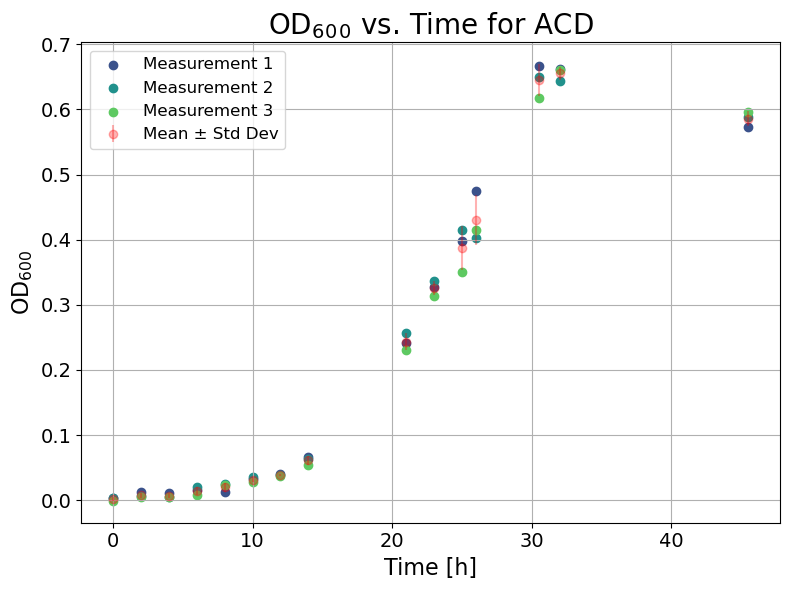

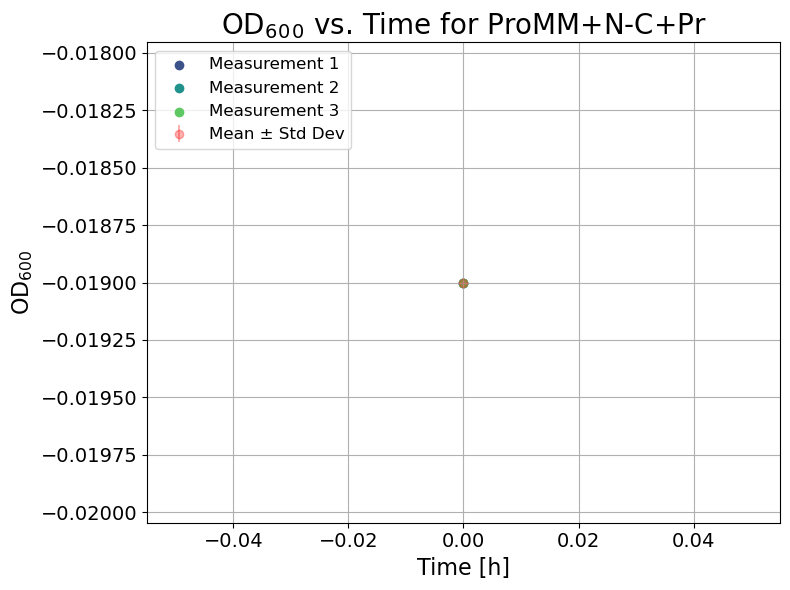

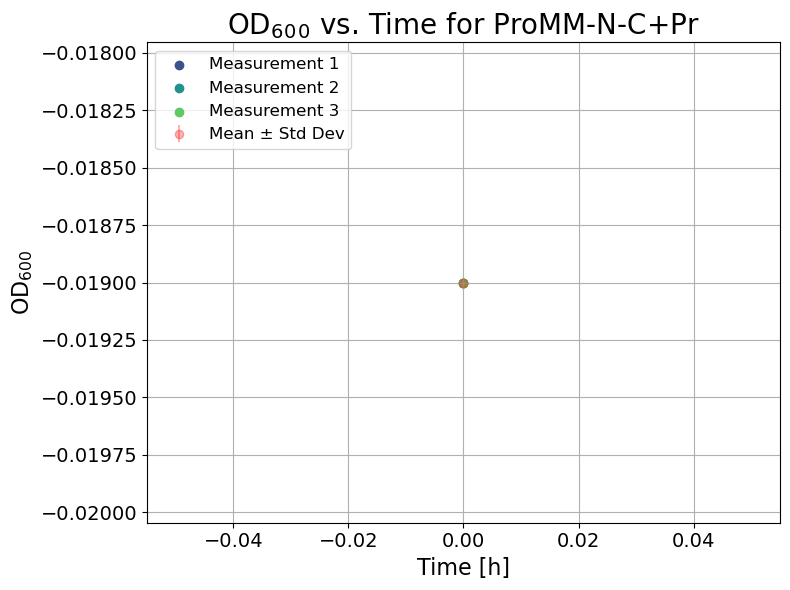

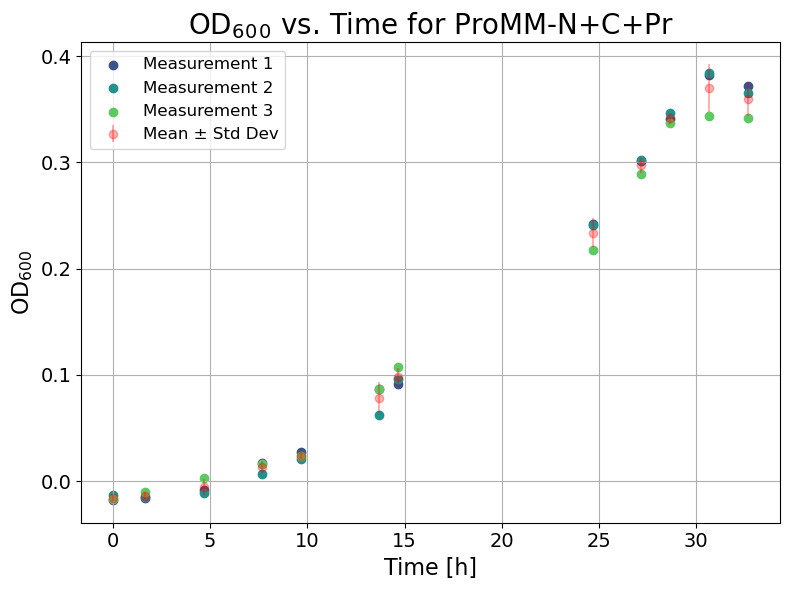

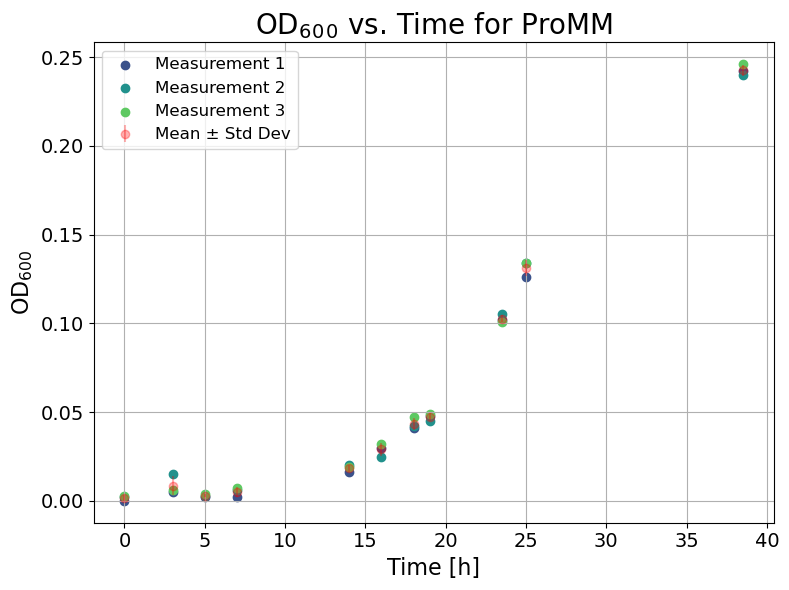

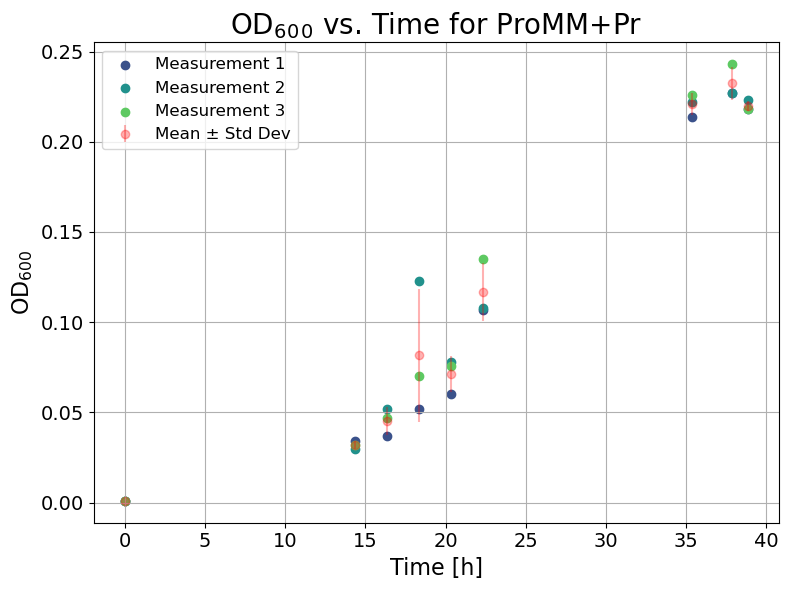

{'ACD':         Time      1      2      3  Time_hr      Mean       Std
 0   00:00:00  0.004  0.004 -0.001      0.0  0.002333  0.002887
 1   02:00:00  0.012  0.006  0.005      2.0  0.007667  0.003786
 2   04:00:00  0.011  0.005  0.005      4.0  0.007000  0.003464
 3   06:00:00  0.016  0.020  0.008      6.0  0.014667  0.006110
 4   08:00:00  0.012  0.025  0.023      8.0  0.020000  0.007000
 5   10:00:00  0.032  0.035  0.028     10.0  0.031667  0.003512
 6   12:00:00  0.041  0.039  0.037     12.0  0.039000  0.002000
 7   14:00:00  0.067  0.064  0.054     14.0  0.061667  0.006807
 8   21:00:00  0.242  0.257  0.231     21.0  0.243333  0.013051
 9   23:00:00  0.328  0.336  0.314     23.0  0.326000  0.011136
 10  25:00:00  0.398  0.415  0.350     25.0  0.387667  0.033710
 11  26:00:00  0.474  0.402  0.415     26.0  0.430333  0.038371
 12  30:30:00  0.667  0.649  0.618     30.5  0.644667  0.024786
 13  32:00:00  0.662  0.644  0.661     32.0  0.655667  0.010116
 14  45:30:00  0.573  0.589  0.59

In [69]:
growth_curves_meanstd(blankcorr_dic)

#### 2. ln(OD$_{600}$) vs. time

In [12]:
'''
The function 'growth_curves_ln()' is used to plot the mean lnOD600 values against elapsed time for each dataset 
as well as the mean and standard deviation (error bars).

DEPENDENCIES: 
    * timetohours()
    * mean_std()

USAGE: growth_curves_ln(DICTIONARY_UPDATED_WITH_MEANSTD)
'''

def growth_curves_ln(OD_dic):
    for key, df in OD_dic.items():
        
        # Convert time to minutes and store original TIME
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Take the natural logarithm of each individual measurement (only for columns 1 to 3)
        log_df = df.iloc[:, 1:4].apply(np.log)  # Apply np.log only to the OD columns
        
        # Create a scatter plot for each triplicate measurement (log-transformed)
        plt.figure(figsize=(8, 6))

        # Calculate the mean and std of the log-transformed values
        log_means, log_stds = mean_std(log_df)

        # Add mean and std columns to the DataFrame for plotting
        df['Log_Mean'] = log_means
        df['Log_Std'] = log_stds

        colors=sns.color_palette("viridis", n_colors=1)

        # Plot the mean of log-transformed values as red scatter points
        plt.scatter(df['Time_hr'], df['Log_Mean'], label='Ln(Mean)', zorder=5, color=colors)

        # Plot the standard deviation of log-transformed values as black error bars
        plt.errorbar(df['Time_hr'], df['Log_Mean'], yerr=df['Log_Std'], fmt='o', color='black', label='± Ln Std Dev', zorder=4)

        # Customize the plot
        plt.title(f"Ln(OD600) vs. Time for {key}", fontsize=14)
        plt.xlabel("Time [h]", fontsize=12)
        plt.ylabel("Ln(OD600)", fontsize=12)
        plt.legend(title="Triplicates", loc='upper left')
        plt.grid()
        plt.tight_layout()

        # Save or display the plot
        #plt.savefig(f"{key}_log_meangrowth.pdf", format='pdf')
        plt.show()

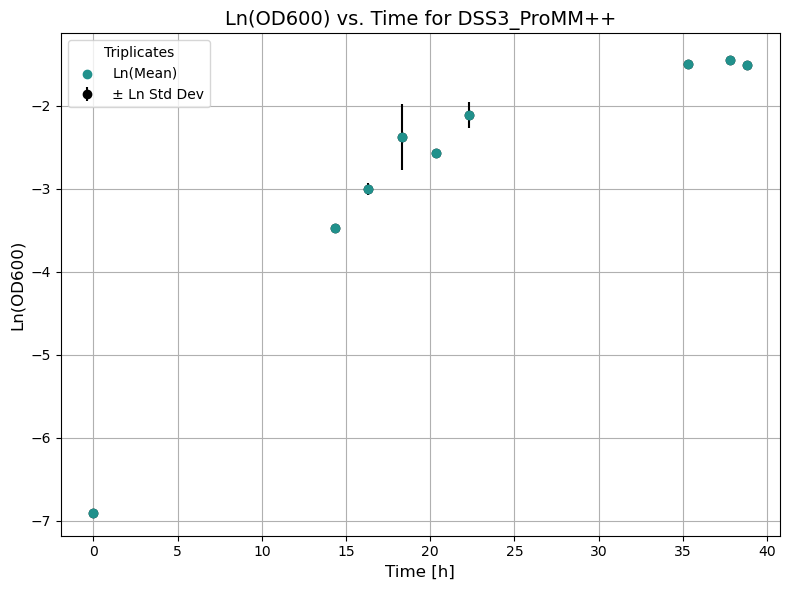

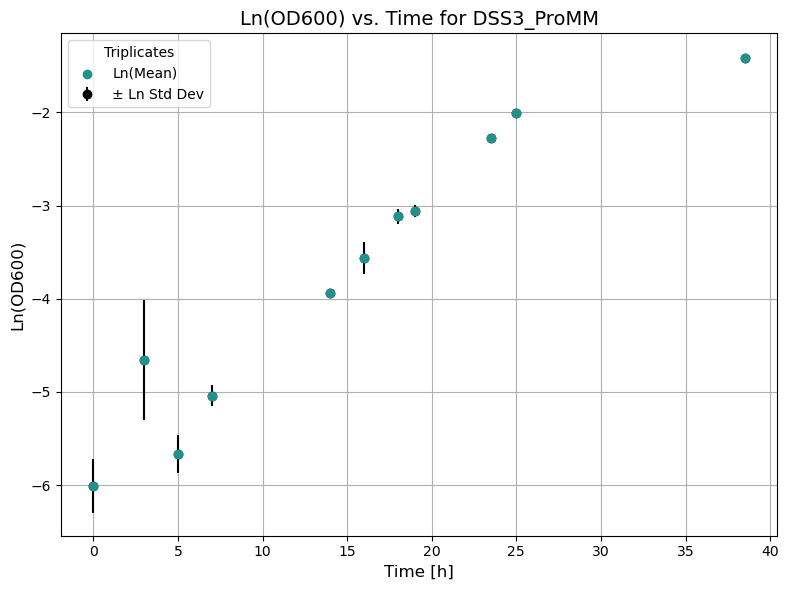

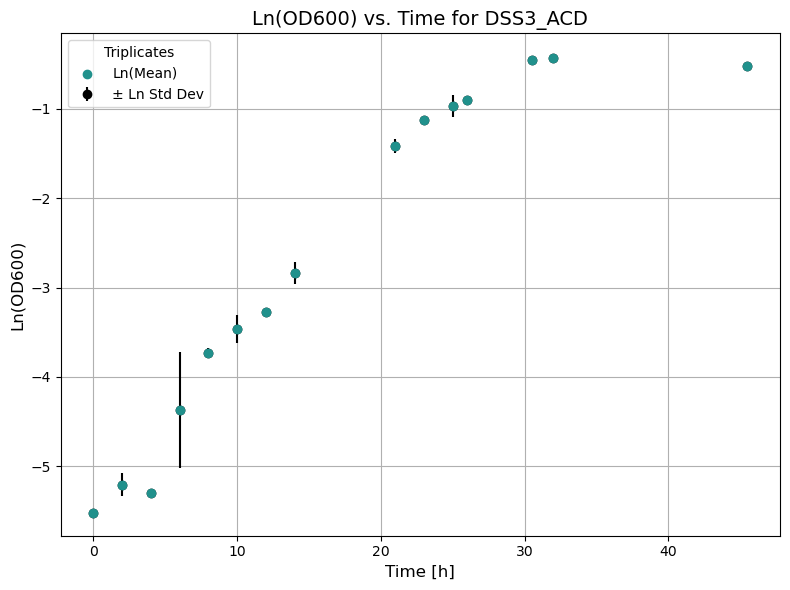

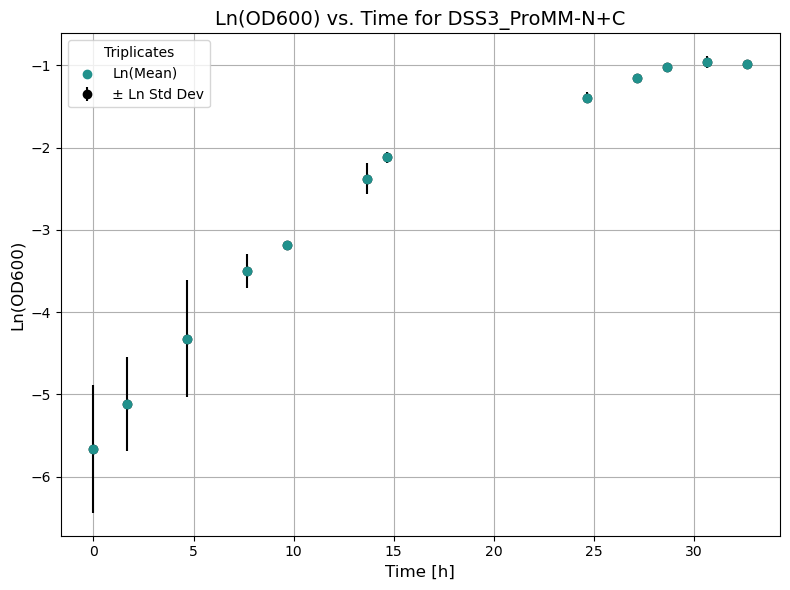

/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


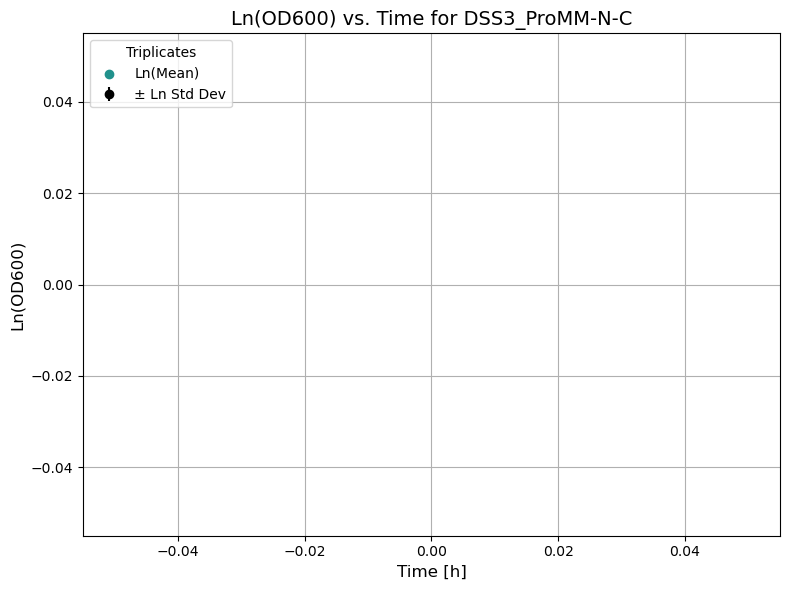

/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


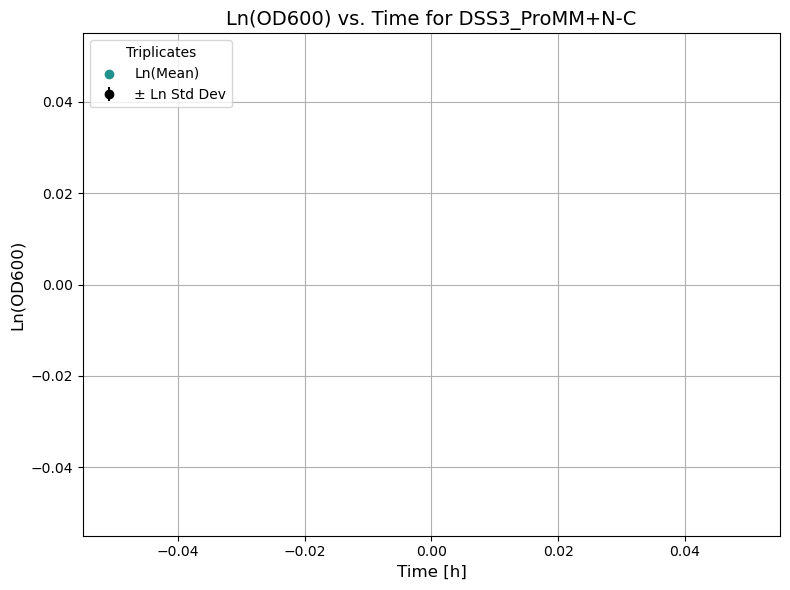

In [13]:
plot_ln(blankcorr_dic)

In [75]:
def growth_rate(filenames_dic):
    for key, df in filenames_dic.items():
        
        # Convert time to minutes and store original TIME
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Take the natural logarithm of each individual measurement (only for columns 1 to 3)
        log_df = df.iloc[:, 1:4].apply(np.log)  # Apply np.log only to the OD columns

        # Calculate the mean and std of the log-transformed values
        log_means, log_stds = mean_std(log_df)

        # Add mean and std columns to the DataFrame for plotting
        df['Log_Mean'] = log_means
        df['Log_Std'] = log_stds

        colors=sns.color_palette("viridis", n_colors=1)

        # Plot the mean of log-transformed values as red scatter points
        plt.figure(figsize=(8, 6))
        plt.scatter(df['Time_hr'], df['Log_Mean'], color=colors, label='Ln(Mean)', zorder=5)

        # Plot the standard deviation of log-transformed values as black error bars
        plt.errorbar(df['Time_hr'], df['Log_Mean'], yerr=df['Log_Std'], fmt='o', color='black', label='± Ln Std Dev', zorder=4)

        # Customize the plot
        plt.title(f"Ln(OD600) vs. Time for {key}", fontsize=14)
        plt.xlabel("Time [h]", fontsize=12)
        plt.ylabel("Ln(OD600)", fontsize=12)
        plt.legend(title="Triplicates", loc='upper left')
        plt.grid()
        plt.tight_layout()
        plt.show()

        # Calculate the derivative of the log-transformed mean values with respect to time
        df['Derivative'] = np.gradient(df['Log_Mean'], df['Time_hr'])

        # Plot the derivative values vs. time
        plt.figure(figsize=(8, 6))
        plt.plot(df['Time_hr'], df['Derivative'], marker='o', color='grey', label='d(Ln(OD600))/dt')
        
        # Customize the plot
        plt.title(f"Growth Rate (d(Ln(OD600))/dt) vs. Time for {key}", fontsize=14)
        plt.xlabel("Time [h]", fontsize=12)
        plt.ylabel("Growth Rate (d(Ln(OD600))/dt)", fontsize=12)
        plt.legend(loc='upper left')
        plt.grid()
        plt.tight_layout()
        plt.show()

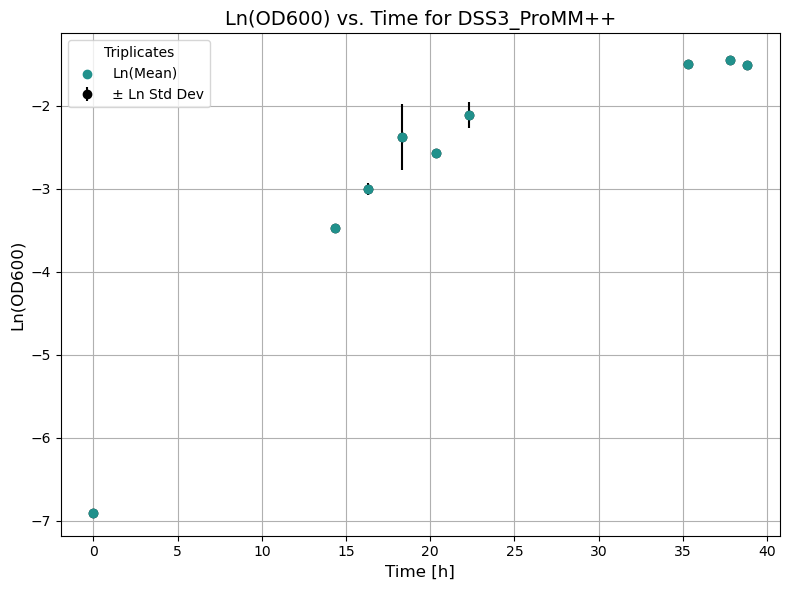

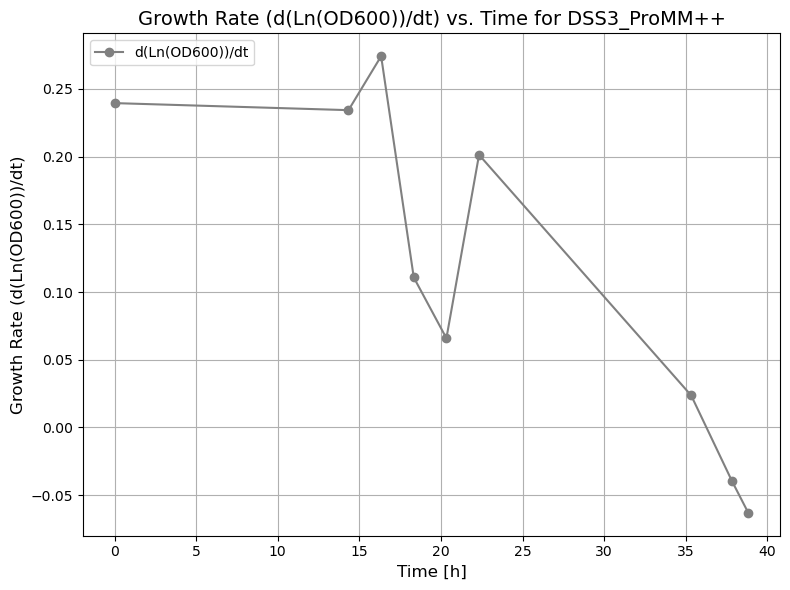

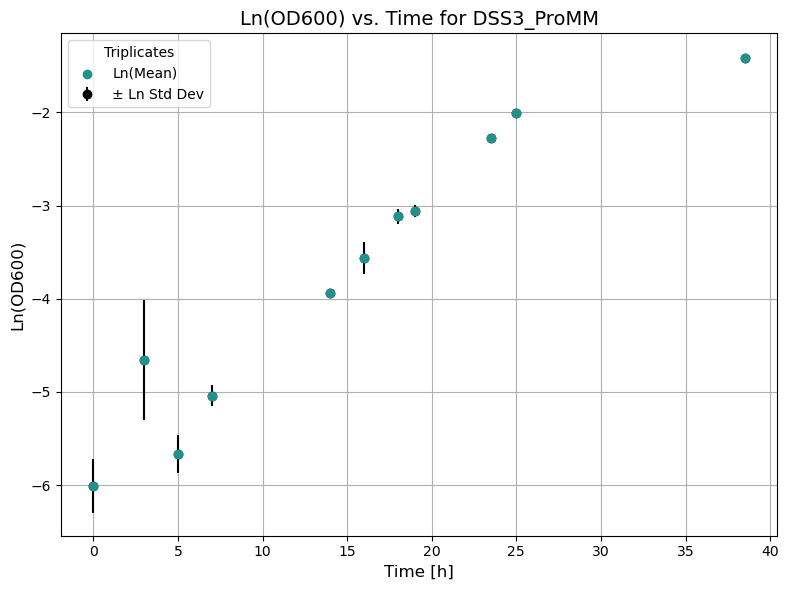

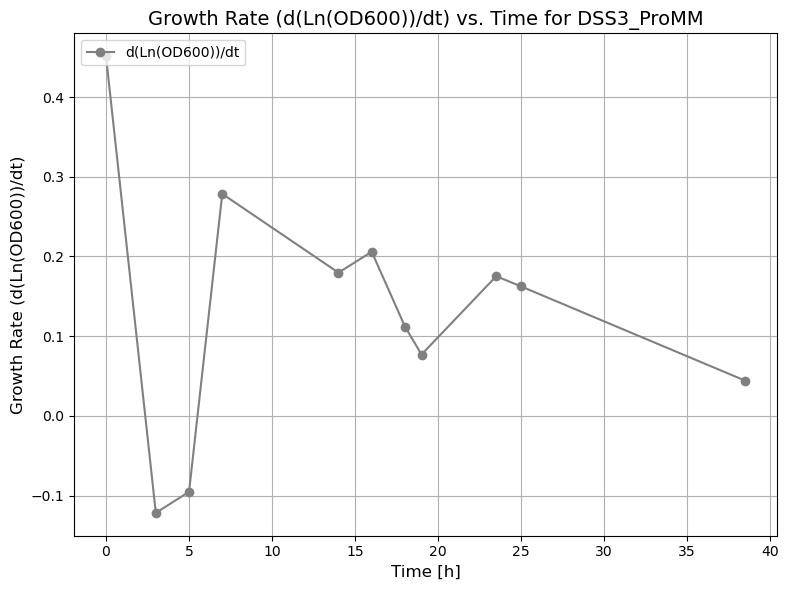

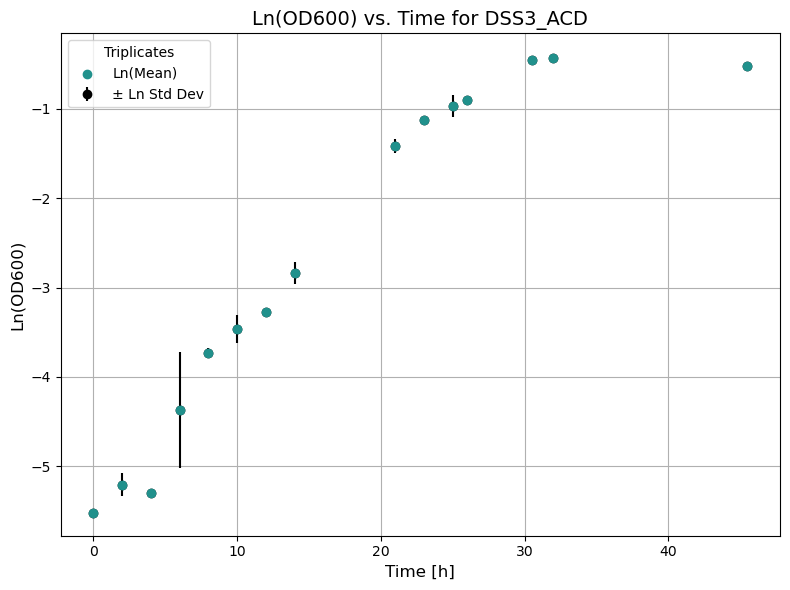

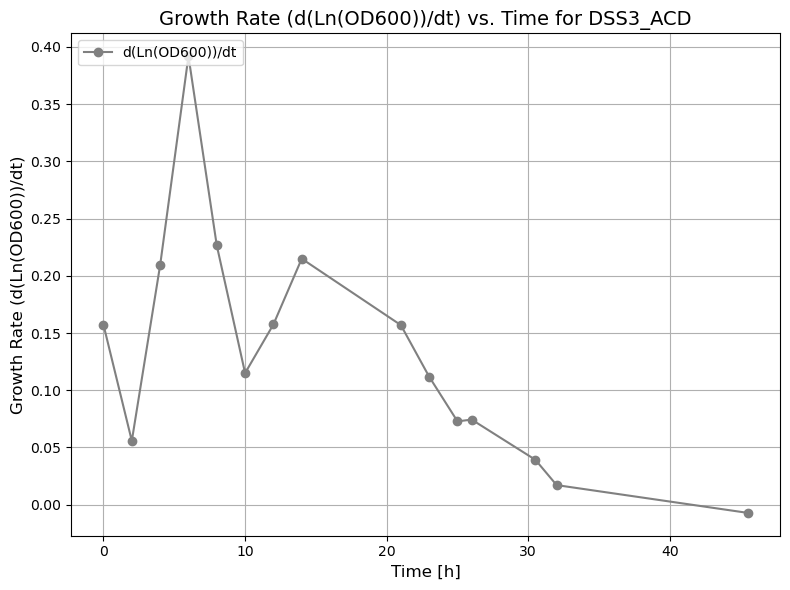

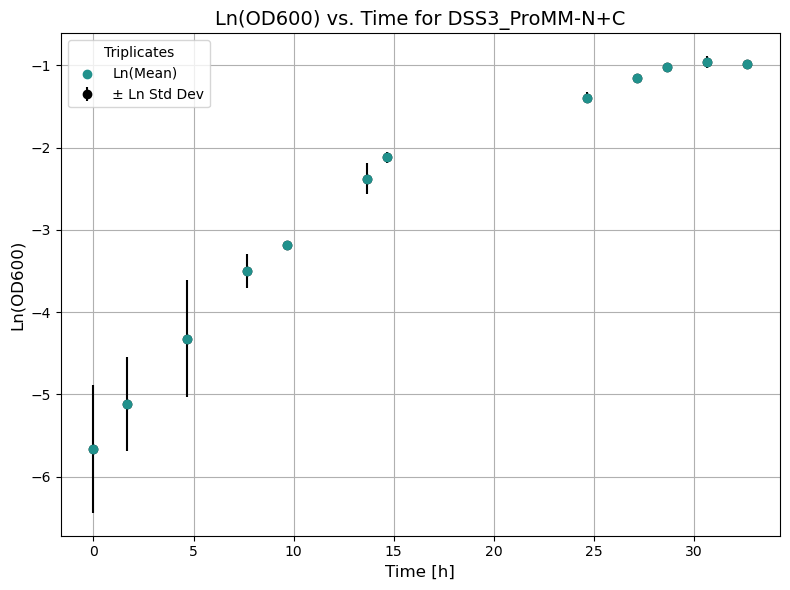

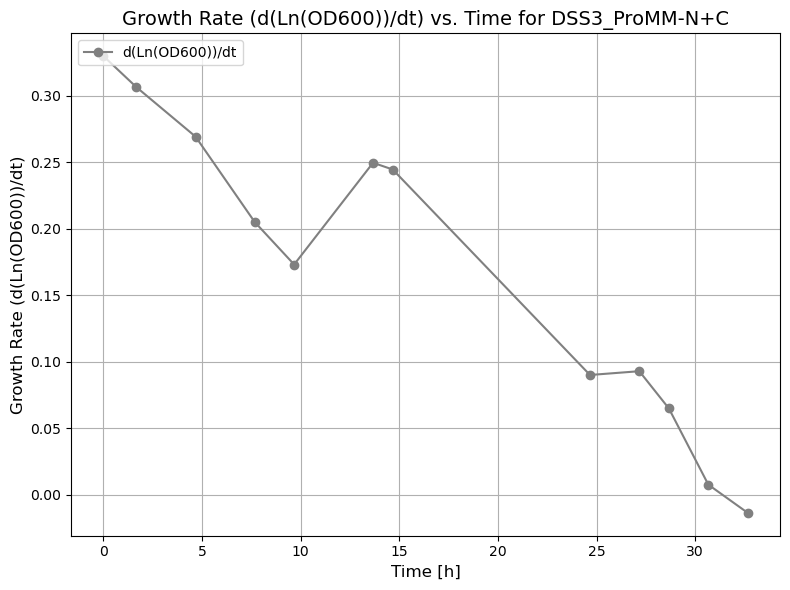

/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


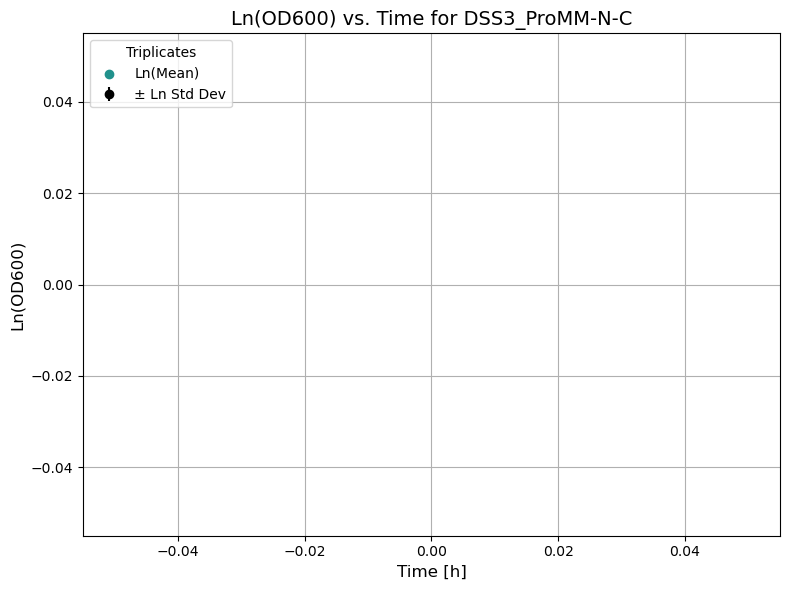

IndexError: index 0 is out of bounds for axis 0 with size 0

In [76]:
growth_rate(blankcorr_dic)

In [77]:
def growth_rate_bar(filenames_dic):
    derivatives = []
    keys = []

    for key, df in filenames_dic.items():
        
        # Convert time to minutes and store original TIME
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Take the natural logarithm of each individual measurement (only for columns 1 to 3)
        log_df = df.iloc[:, 1:4].apply(np.log)  # Apply np.log only to the OD columns

        # Calculate the mean and std of the log-transformed values
        log_means, log_stds = mean_std(log_df)

        # Add mean and std columns to the DataFrame for plotting
        df['Log_Mean'] = log_means
        df['Log_Std'] = log_stds

        # Remove unusual values
        if key == list(filenames_dic.keys())[0]:
            df['Log_Mean'] = log_means.drop(index=3)  # Fourth data point (index 3)
            df['Log_Std'] = log_stds.drop(index=3)
        #elif key == list(filenames_dic.keys())[5]:
            #df['Log_Mean'] = log_means.drop(index=5)
            #df['Log_Std'] = log_stds.drop(index=5)

        colors=sns.color_palette("viridis", n_colors=9)

        # Calculate the derivative of the log-transformed mean values with respect to time
        df['Derivative'] = np.gradient(df['Log_Mean'], df['Time_hr'])
        derivative = df['Derivative'].max()
        derivative_std = df['Derivative'].std()

        derivatives.append((derivative, derivative_std))
        keys.append(key)

    # Create a bar plot for the selected derivatives
    plt.figure(figsize=(10, 6))
    for i, (derivative, derivative_std) in enumerate(derivatives):
        plt.bar(keys[i], derivative, yerr=derivative_std, capsize=5, label=f'{keys[i]}', color=colors[i])

    # Customize the plot
    plt.title("Max. Growth Rate [d(Ln(OD600))/dt]", fontsize=14)
    plt.xlabel("Sample", fontsize=12)
    plt.ylabel("Growth Rate [d(Ln(OD600))/dt]", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    #plt.savefig(f"{key}_bar.pdf", format="pdf")
    plt.show()

In [78]:
growth_rate_bar(blankcorr_dic)

/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [79]:
# Bar plot without 0 values, sorted
def growth_rate_bar(filenames_dic):
    derivatives = []
    
    for key, df in filenames_dic.items():
        # Convert time to minutes and store original TIME
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Take the natural logarithm of each individual measurement (only for columns 1 to 3)
        log_df = df.iloc[:, 1:4].apply(np.log)  # Apply np.log only to the OD columns

        # Calculate the mean and std of the log-transformed values
        log_means, log_stds = mean_std(log_df)

        # Add mean and std columns to the DataFrame for plotting
        df['Log_Mean'] = log_means
        df['Log_Std'] = log_stds

        # Remove unusual values
        #if key == list(filenames_dic.keys())[0]:
         #   df['Log_Mean'] = log_means.drop(index=3)  # Fourth data point (index 3)
          #  df['Log_Std'] = log_stds.drop(index=3)

        colors = sns.color_palette("viridis", n_colors=9)

        # Calculate the derivative of the log-transformed mean values with respect to time
        df['Derivative'] = np.gradient(df['Log_Mean'], df['Time_hr'])
        derivative = df['Derivative'].max()
        derivative_std = df['Derivative'].std()

        # Store key, derivative, and std together
        derivatives.append((key, derivative, derivative_std))

    # **Define a custom order for the samples**
    custom_order = ["DSS3_ACD", "DSS3_ProMM", "DSS3_ProMM++", "DSS3_ProMM-N+C"]

    # **Sort derivatives based on the custom order**
    sorted_derivatives = sorted(derivatives, key=lambda x: custom_order.index(x[0]))

    # **Unpack sorted values**
    sorted_keys = [item[0] for item in sorted_derivatives]
    sorted_values = [item[1] for item in sorted_derivatives]
    sorted_stds = [item[2] for item in sorted_derivatives]

    # **Create a bar plot with sorted order**
    plt.figure(figsize=(10, 6))
    for i, (key, derivative, derivative_std) in enumerate(zip(sorted_keys, sorted_values, sorted_stds)):
        plt.bar(key, derivative, yerr=derivative_std, capsize=5, color=colors[i], label=key)

    # Customize the plot
    plt.title("Max. Growth Rate [d(Ln(OD600))/dt]", fontsize=14)
    plt.xlabel("Sample", fontsize=12)
    plt.ylabel("Growth Rate [d(Ln(OD600))/dt]", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    #plt.savefig(f"{key}_sortedgrowth.pdf", format="pdf")
    plt.show()

In [81]:
# Bar plot for sorted with 0 values
def growth_rate_bar(filenames_dic):
    derivatives = []

    for key, df in filenames_dic.items():
        df['Time_hr'] = df['Time'].apply(timetohours)
        log_df = df.iloc[:, 1:4].apply(np.log)

        log_means, log_stds = mean_std(log_df)
        df['Log_Mean'] = log_means
        df['Log_Std'] = log_stds

        # SAFETY CHECK: Make sure we have enough valid data points
        if (
            'Log_Mean' in df.columns and 'Time_hr' in df.columns and
            df['Log_Mean'].notna().sum() >= 2 and
            df['Time_hr'].notna().sum() >= 2
        ):
            try:
                df['Derivative'] = np.gradient(df['Log_Mean'], df['Time_hr'])
                derivative = df['Derivative'].max()
                derivative_std = df['Derivative'].std()

                if not np.isfinite(derivative):
                    derivative = 0
                    derivative_std = 0
            except Exception as e:
                print(f"Could not calculate gradient for {key}: {e}")
                derivative = 0
                derivative_std = 0
        else:
            print(f"Skipping {key} due to insufficient data for gradient.")
            derivative = 0
            derivative_std = 0

        derivatives.append((key, derivative, derivative_std))

    # Define a custom order for the samples
    custom_order = ["DSS3_ACD", "DSS3_ProMM", "DSS3_ProMM++", "DSS3_ProMM-N-C", "DSS3_ProMM-N+C", "DSS3_ProMM+N-C"]

    # Sort based on the custom order
    sorted_derivatives = sorted(derivatives, key=lambda x: custom_order.index(x[0]))

    sorted_keys = [item[0] for item in sorted_derivatives]
    sorted_values = [item[1] for item in sorted_derivatives]
    sorted_stds = [item[2] for item in sorted_derivatives]

    # Plot
    plt.figure(figsize=(10, 6))
    colors = sns.color_palette("viridis", n_colors=len(sorted_keys))

    for i, (key, derivative, derivative_std) in enumerate(zip(sorted_keys, sorted_values, sorted_stds)):
        plt.bar(key, derivative, yerr=derivative_std, capsize=5, color=colors[i], label=key)

    plt.title("Max. Growth Rate [d(Ln(OD600))/dt]", fontsize=14)
    plt.xlabel("Sample", fontsize=12)
    plt.ylabel("Growth Rate [d(Ln(OD600))/dt]", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.legend()
    #plt.savefig(f"{key}_sortedgrowth.pdf", format="pdf")
    plt.show()

Skipping DSS3_ProMM-N-C due to insufficient data for gradient.
Skipping DSS3_ProMM+N-C due to insufficient data for gradient.


/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


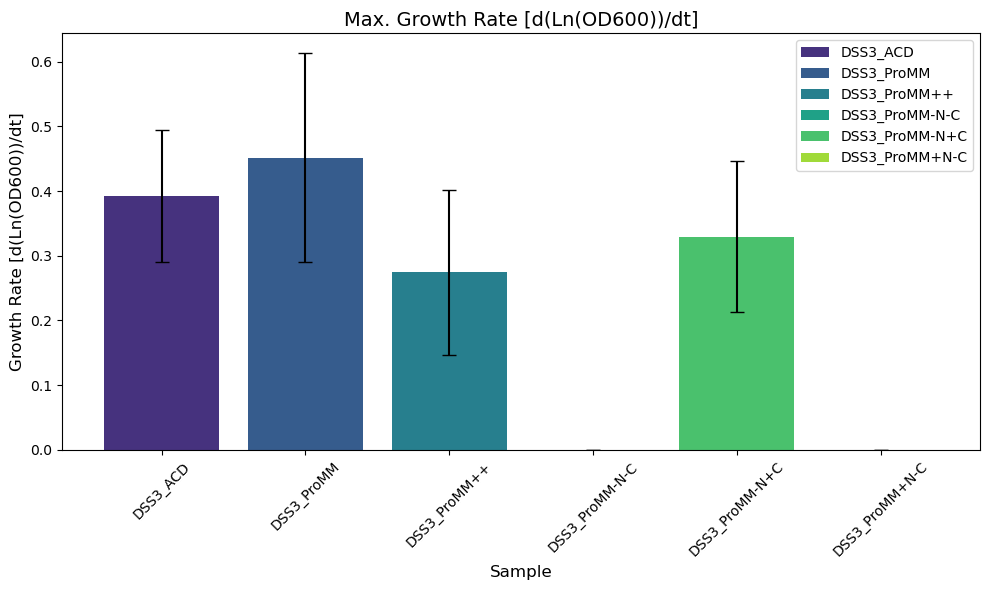

In [82]:
growth_rate_bar(blankcorr_dic)

### ANOVA - Analysis of Variance 

An ANOVA test can be used to check if the difference between mean values is significant. Here for instance, we can determine if the difference in growth rates is significant, due to the different media conditions used. 

Hypothesis involved:
A one-way ANOVA has the below given null and alternative hypotheses:

H0 (null hypothesis): μ1 = μ2 = μ3 = … = μk (It implies that the means of all the population are equal)
H1 (null hypothesis): It states that there will be at least one population mean that differs from the rest.

ANOVA results: F = 15.1842, p = 0.0011499096827440503


/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_12443/3689899610.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sample", y="Growth Rate", data=df_plot, palette="viridis", order=custom_order)


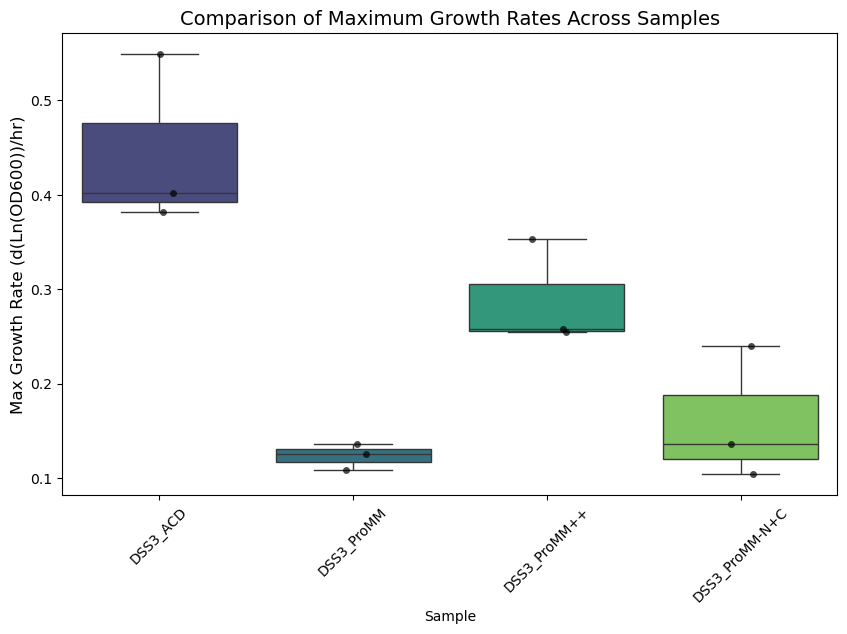

In [34]:
def growth_rate_anova(filenames_dic):
    growth_rates = {}  # Dictionary to store growth rates per sample

    for key, df in filenames_dic.items():
        # Convert time to hours
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Log-transform OD600 values (columns 1 to 3)
        log_df = df.iloc[:, 1:4].apply(np.log)

        # Compute derivatives (growth rates)
        derivatives = log_df.apply(lambda col: np.gradient(col, df['Time_hr']))

        # Extract max growth rate for each triplicate
        max_growth_rates = derivatives.max(axis=0).tolist()  # Extract max for each column
        growth_rates[key] = max_growth_rates  # Store as list in dictionary

    # Convert dictionary to list of lists for ANOVA
    grouped_growth_rates = list(growth_rates.values())

    # Perform ANOVA if we have at least two groups
    if len(grouped_growth_rates) > 1:
        f_stat, p_value = f_oneway(*grouped_growth_rates)
        print(f"ANOVA results: F = {f_stat:.4f}, p = {p_value:}")
    else:
        print("Not enough groups for ANOVA.")

    # Prepare data for boxplot (long format)
    data = []
    for sample, rates in growth_rates.items():
        for rate in rates:
            data.append({'Sample': sample, 'Growth Rate': rate})
    
    df_plot = pd.DataFrame(data)

    # Define a custom order for the samples**
    custom_order = ["DSS3_ACD", "DSS3_ProMM", "DSS3_ProMM++", "DSS3_ProMM-N+C"]

    # Visualization (Box Plot)
    plt.figure(figsize=(10, 6))
    sns.boxplot(x="Sample", y="Growth Rate", data=df_plot, palette="viridis", order=custom_order)
    sns.stripplot(x="Sample", y="Growth Rate", data=df_plot, color='black', alpha=0.7, jitter=True, order=custom_order)  # Show triplicates
    plt.title("Comparison of Maximum Growth Rates Across Samples", fontsize=14)
    plt.ylabel("Max Growth Rate (d(Ln(OD600))/hr)", fontsize=12)
    plt.xticks(rotation=45)
    #plt.savefig("DSS3_boxplot_growth_rate.pdf", format="pdf")
    plt.show()

    return df_plot  # Return the processed dataframe for reference

# Run ANOVA on growth rates
df_growth_rates = growth_rate_anova(filenames_dic)

### Growth rate from linear regression
In a next step, we will conduct a linear regression analysis to the datapoints identified in the log-phase to determine the growth rates. 
Instead of using the derivative to get at the growth rate, this code aims to determine the growth rate from the slope of a linear regresson analysis. This is more accurate so in the paper, we will continue using this method. 

In [36]:
def growth_rate_linreg(filenames_dic):
    for key, df in filenames_dic.items():
        
        # Convert time to minutes and store original TIME
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Take the natural logarithm of each individual measurement (only for columns 1 to 3)
        log_df = df.iloc[:, 1:4].apply(np.log)  # Apply np.log only to the OD columns

        # Calculate the mean and std of the log-transformed values
        log_means, log_stds = mean_std(log_df)

        # Add mean and std columns to the DataFrame for plotting
        df['Log_Mean'] = log_means
        df['Log_Std'] = log_stds

        colors=sns.color_palette("viridis", n_colors=1)

        # Linear Regression for Growth Rate Calculation
                
        if key == list(filenames_dic.keys())[0]:
            y = log_means.drop(index=[6, 7, 8]).values
            X = df['Time_hr'].drop(index=[6, 7, 8]).values.reshape(-1, 1)
        elif key == list(filenames_dic.keys())[1]:
            y = log_means.drop(index=[0,1,2,3,10]).values
            X = df['Time_hr'].drop(index=[0,1,2,3,10]).values.reshape(-1, 1)
        elif key == list(filenames_dic.keys())[2]:
            y = log_means.drop(index=[12,13,14]).values
            X = df['Time_hr'].drop(index=[12,13,14]).values.reshape(-1, 1)
        elif key == list(filenames_dic.keys())[3]:
            y = log_means.drop(index=[0,7,8,9,10,11]).values
            X = df['Time_hr'].drop(index=[0,7,8,9,10,11]).values.reshape(-1, 1)

        if len(X) < 2:
            print(f"Not enough data points for regression in {key}. Setting growth rate to 0.")
            slope = 0
            R_2 = 0
            regression_done = False
        else:
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]
            R_2 = model.score(X, y)
            y_pred = model.predict(X)
            error = mean_squared_error(y, y_pred)
            print(f"Growth Rate: {slope}")
            print(f"Mean squared error: {error}")
            print(f"Coefficient of determination R2: {R_2}")
            regression_done = True

        # Plot the mean of log-transformed values as red scatter points
        plt.figure(figsize=(8, 6))
        plt.scatter(df['Time_hr'], df['Log_Mean'], color=colors, label='Ln(Mean)', zorder=5)

        if regression_done:
            plt.plot(X, y_pred, color='red', label='Linear Fit')

        plt.errorbar(df['Time_hr'], df['Log_Mean'], yerr=df['Log_Std'], fmt='o', color='black', label='± Ln Std Dev', zorder=4)
        plt.title(f"Ln(OD600) vs. Time for {key}", fontsize=14)
        plt.xlabel("Time [h]", fontsize=12)
        plt.ylabel("Ln(OD600)", fontsize=12)
        plt.legend(title="Triplicates", loc='upper left')
        plt.grid()
        plt.tight_layout()
        plt.savefig(f"{key}_linearregression.pdf", format="pdf")
        plt.show()

Growth Rate: 0.22024736016856933
Mean squared error: 0.05579607532491427
Coefficient of determination R2: 0.9788945904894193


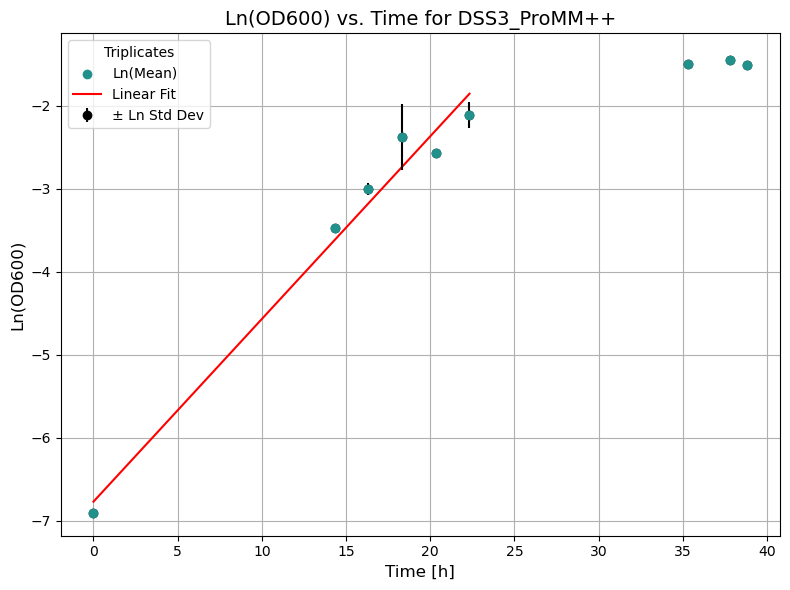

Growth Rate: 0.172756379480139
Mean squared error: 0.0018996141058489119
Coefficient of determination R2: 0.9958151225754025


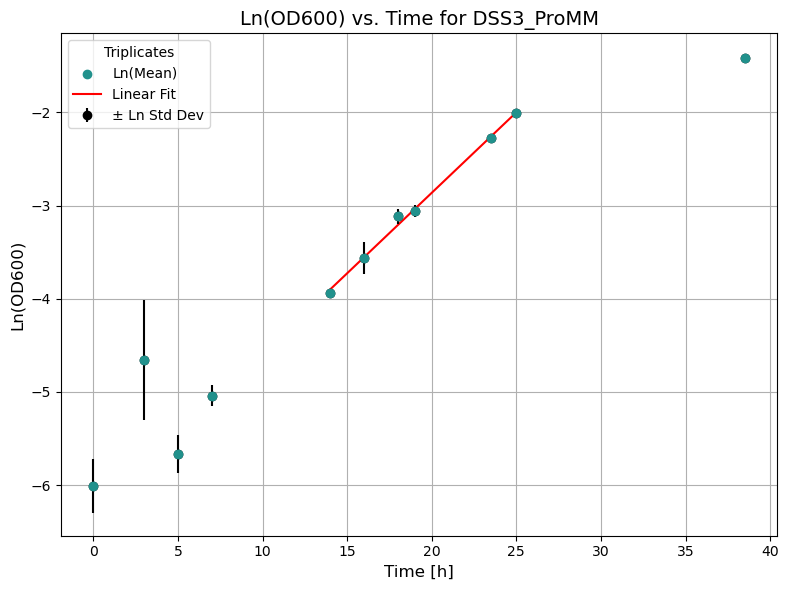

Growth Rate: 0.18818695978721242
Mean squared error: 0.04310732882420421
Coefficient of determination R2: 0.9845516883729962


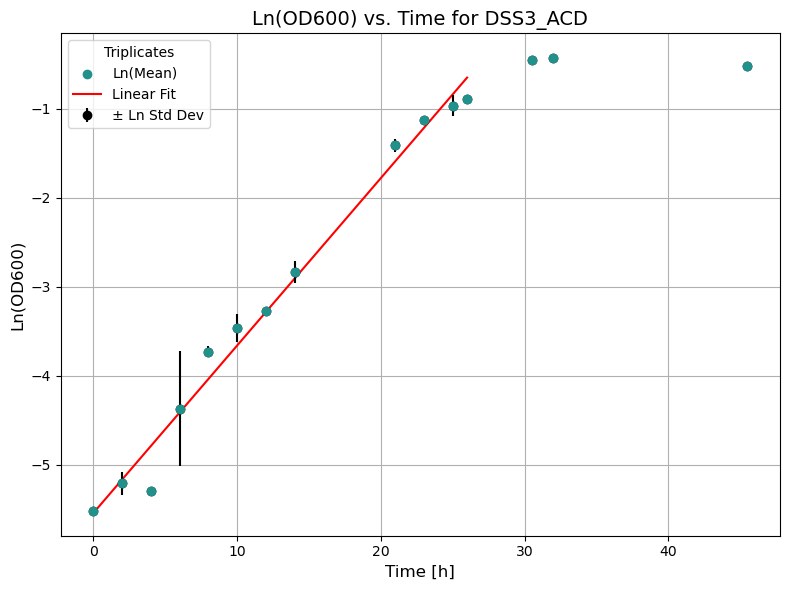

Growth Rate: 0.2251827807686021
Mean squared error: 0.007193157338142583
Coefficient of determination R2: 0.99339440119906


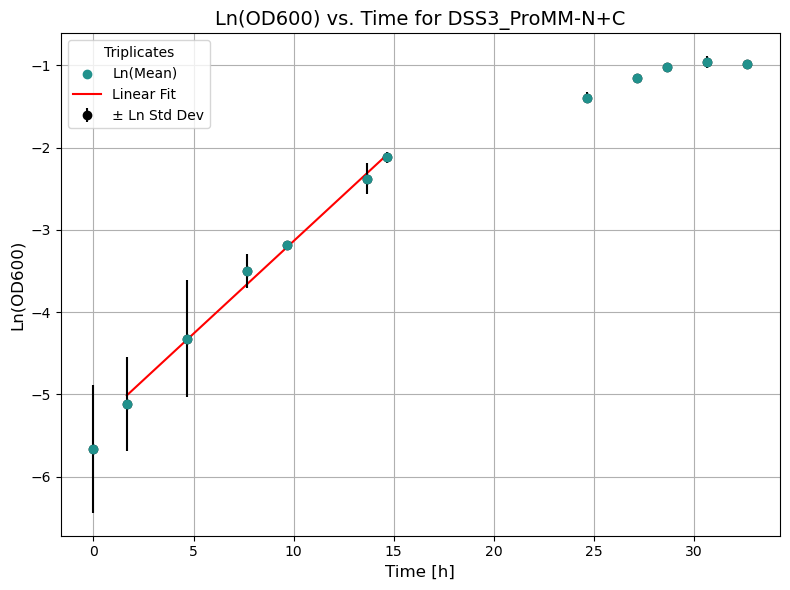

Growth Rate: 0.2251827807686021
Mean squared error: 0.007193157338142583
Coefficient of determination R2: 0.99339440119906


/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


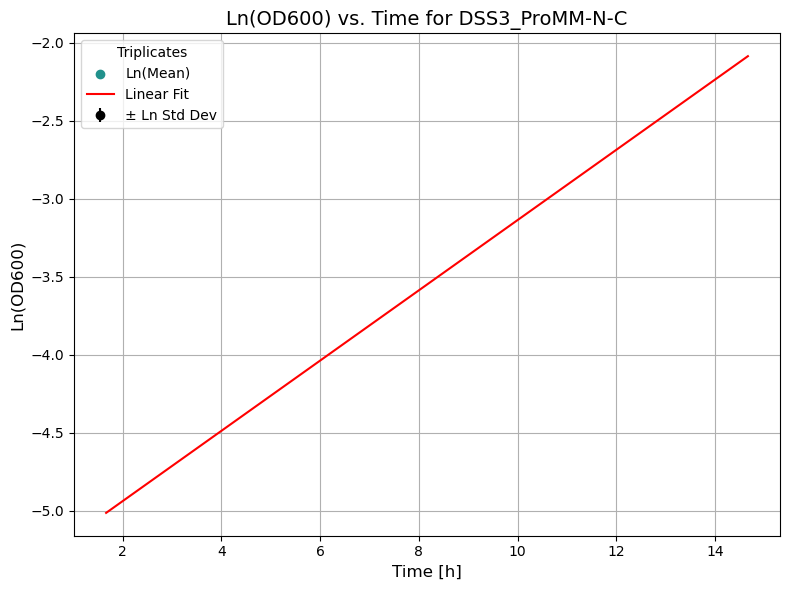

/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Growth Rate: 0.2251827807686021
Mean squared error: 0.007193157338142583
Coefficient of determination R2: 0.99339440119906


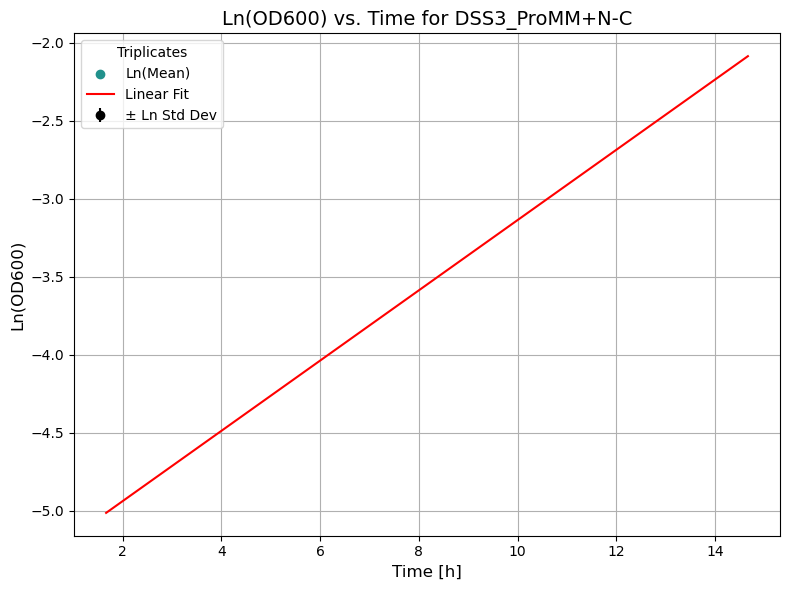

In [37]:
growth_rate_linreg(blankcorr_dic)

In [22]:
def growth_rate_linreg_barplot(filenames_dic):
    growth_rates = {}
    r2_values = {}
    std_errors = {}

    for key, df in filenames_dic.items():
        
        # Convert time to hours
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Log-transform OD600 values
        log_df = df.iloc[:, 1:4].apply(np.log)

        # Calculate the mean and std of log-transformed values
        log_means, log_stds = mean_std(log_df)

        df['Log_Mean'] = log_means
        df['Log_Std'] = log_stds

        # Define the subset of data for linear regression
        if key == list(filenames_dic.keys())[0]:
            y = log_means.drop(index=[6, 7, 8]).values
            X = df['Time_hr'].drop(index=[6, 7, 8]).values.reshape(-1, 1)
        elif key == list(filenames_dic.keys())[1]:
            y = log_means.drop(index=[0,1,2,3,10]).values
            X = df['Time_hr'].drop(index=[0,1,2,3,10]).values.reshape(-1, 1)
        elif key == list(filenames_dic.keys())[2]:
            y = log_means.drop(index=[12,13,14]).values
            X = df['Time_hr'].drop(index=[12,13,14]).values.reshape(-1, 1)
        elif key == list(filenames_dic.keys())[3]:
            y = log_means.drop(index=[0,7,8,9,10,11]).values
            X = df['Time_hr'].drop(index=[0,7,8,9,10,11]).values.reshape(-1, 1)

        # Linear regression
        model = LinearRegression()
        model.fit(X, y)
        slope = model.coef_[0]  
        R_2 = model.score(X, y)

        # Calculate standard error of the slope
        n = len(X)
        y_pred = model.predict(X)
        residuals = y - y_pred
        std_error = np.sqrt(np.sum(residuals**2) / (n - 2)) / np.sqrt(np.sum((X - np.mean(X))**2))

        growth_rates[key] = slope
        r2_values[key] = R_2
        std_errors[key] = std_error

        # Print stats
        print(f"{key} - Growth Rate: {slope:.4f}, R²: {R_2:.4f}, Std Error: {std_error:.4f}")

        # Plot regression
        plt.figure(figsize=(8, 6))
        plt.scatter(df['Time_hr'], df['Log_Mean'], label='Ln(Mean)', zorder=5)
        plt.plot(X, model.predict(X), color='red', label='Linear Fit')

        plt.errorbar(df['Time_hr'], df['Log_Mean'], yerr=df['Log_Std'], fmt='o', color='black', label='± Ln Std Dev', zorder=4)

        plt.title(f"Ln(OD600) vs. Time for {key}", fontsize=14)
        plt.xlabel("Time [h]", fontsize=12)
        plt.ylabel("Ln(OD600)", fontsize=12)
        plt.legend(title="Triplicates", loc='upper left')
        plt.grid()
        plt.tight_layout()
        #plt.savefig(f"{key}_linearregression.pdf", format="pdf")
        plt.show()

    # Plotting the bar plot with error bars

    # Define a custom order for the samples
    custom_order = ["DSS3_ACD", "DSS3_ProMM", "DSS3_ProMM++", "DSS3_ProMM-N-C", "DSS3_ProMM-N+C", "DSS3_ProMM+N-C"]

    # Ensure all keys are in the custom order
    ordered_growth_rates = {key: growth_rates[key] for key in custom_order if key in growth_rates}
    ordered_r2_values = {key: r2_values[key] for key in custom_order if key in r2_values}
    ordered_std_errors = {key: std_errors[key] for key in custom_order if key in std_errors}

    fig, ax = plt.subplots(figsize=(10, 6))

    # Bar plot with seaborn
    sns.barplot(x=list(ordered_growth_rates.keys()), y=list(ordered_growth_rates.values()), palette='viridis', ax=ax)

    # Add error bars using matplotlib
    x_positions = np.arange(len(ordered_growth_rates))
    ax.errorbar(x_positions, list(ordered_growth_rates.values()), yerr=list(ordered_std_errors.values()), fmt='none', capsize=5, color='black')
    
    plt.title("Maximum Growth Rate (d(Ln(OD600))/dt)", fontsize=14)
    plt.ylabel("Max Growth Rate (d(Ln(OD600))/dt)", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    #plt.savefig("Linregress_barplot.pdf", format="pdf")
    plt.show()
    
    return growth_rates, r2_values, std_errors

In [34]:
### Plot the same bar plot including 0 values for the two cultures that did not grow. 
def growth_rate_linreg_barplot(filenames_dic):
    growth_rates = {}
    r2_values = {}
    std_errors = {}

    for key, df in filenames_dic.items():
        # Convert time to hours
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Log-transform OD600 values
        log_df = df.iloc[:, 1:4].apply(np.log)

        # Calculate the mean and std of log-transformed values
        log_means, log_stds = mean_std(log_df)

        df['Log_Mean'] = log_means
        df['Log_Std'] = log_stds

        # Define the subset of data for linear regression
        if key == list(filenames_dic.keys())[0]:
            drop_idx = [6, 7, 8]
        elif key == list(filenames_dic.keys())[1]:
            drop_idx = [0, 1, 2, 3, 10]
        elif key == list(filenames_dic.keys())[2]:
            drop_idx = [12, 13, 14]
        elif key == list(filenames_dic.keys())[3]:
            drop_idx = [0, 7, 8, 9, 10, 11]
        else:
            drop_idx = []

        y = log_means.drop(index=drop_idx).values
        X = df['Time_hr'].drop(index=drop_idx).values.reshape(-1, 1)

        # Check if y contains only -inf or all equal (which means no growth)
        if np.all(np.isneginf(y)) or np.all(y == y[0]):
            slope = 0
            R_2 = 0
            std_error = 0
            y_pred = np.full_like(y, fill_value=np.mean(y))
            print(f"{key} - No measurable growth. Growth Rate set to 0.")
        else:
            # Linear regression
            model = LinearRegression()
            model.fit(X, y)
            slope = model.coef_[0]
            R_2 = model.score(X, y)

            # Standard error of the slope
            n = len(X)
            y_pred = model.predict(X)
            residuals = y - y_pred
            std_error = np.sqrt(np.sum(residuals**2) / (n - 2)) / np.sqrt(np.sum((X - np.mean(X))**2))
            print(f"{key} - Growth Rate: {slope:.4f}, R²: {R_2:.4f}, Std Error: {std_error:.4f}")

        growth_rates[key] = slope
        r2_values[key] = R_2
        std_errors[key] = std_error

        # Plot regression
        plt.figure(figsize=(8, 6))
        plt.scatter(df['Time_hr'], df['Log_Mean'], label='Ln(Mean)', zorder=5)
        if slope != 0:
            plt.plot(X, y_pred, color='red', label='Linear Fit')
        plt.errorbar(df['Time_hr'], df['Log_Mean'], yerr=df['Log_Std'], fmt='o', color='black', label='± Ln Std Dev', zorder=4)

        plt.title(f"Ln(OD600) vs. Time for {key}", fontsize=14)
        plt.xlabel("Time [h]", fontsize=12)
        plt.ylabel("Ln(OD600)", fontsize=12)
        plt.legend(title="Triplicates", loc='upper left')
        plt.grid()
        plt.tight_layout()
        #plt.savefig(f"{key}_linearregression.pdf", format="pdf")
        plt.show()

    # Plotting the bar plot with error bars
    custom_order = ["DSS3_ACD", "DSS3_ProMM", "DSS3_ProMM++", "DSS3_ProMM-N-C", "DSS3_ProMM-N+C", "DSS3_ProMM+N-C"]

    ordered_growth_rates = {key: growth_rates[key] for key in custom_order if key in growth_rates}
    ordered_r2_values = {key: r2_values[key] for key in custom_order if key in r2_values}
    ordered_std_errors = {key: std_errors[key] for key in custom_order if key in std_errors}

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.barplot(x=list(ordered_growth_rates.keys()), y=list(ordered_growth_rates.values()), palette='viridis', ax=ax)

    x_positions = np.arange(len(ordered_growth_rates))
    ax.errorbar(x_positions, list(ordered_growth_rates.values()), yerr=list(ordered_std_errors.values()), fmt='none', capsize=5, color='black')

    plt.title("Maximum Growth Rate (d(Ln(OD600))/dt)", fontsize=14)
    plt.ylabel("Max Growth Rate (d(Ln(OD600))/dt)", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("Linregress_barplot.pdf", format="pdf")
    plt.show()

    return growth_rates, r2_values, std_errors

DSS3_ProMM++ - Growth Rate: 0.2202, R²: 0.9789, Std Error: 0.0162


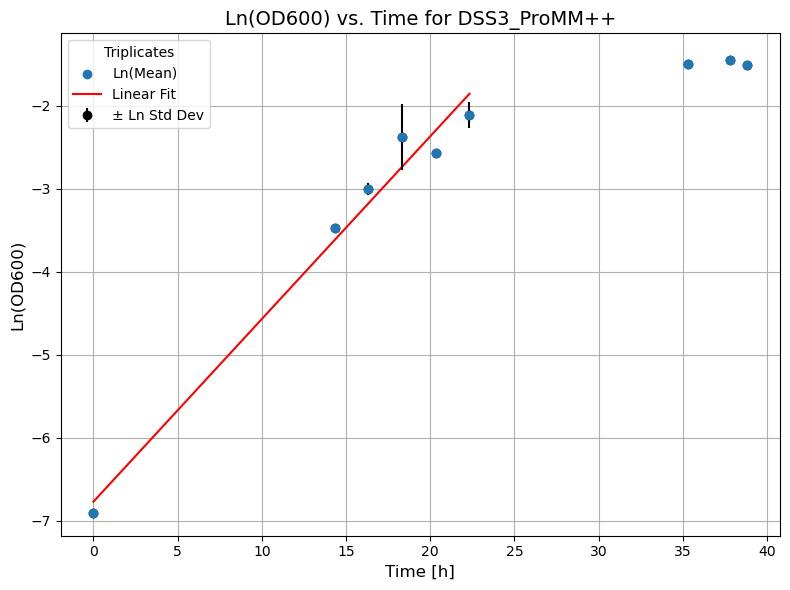

DSS3_ProMM - Growth Rate: 0.1728, R²: 0.9958, Std Error: 0.0056


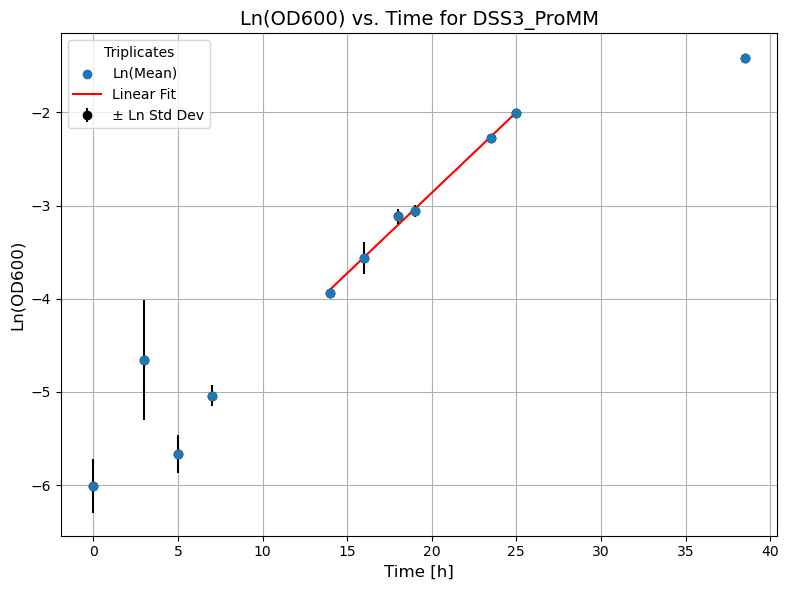

DSS3_ACD - Growth Rate: 0.1882, R²: 0.9846, Std Error: 0.0075


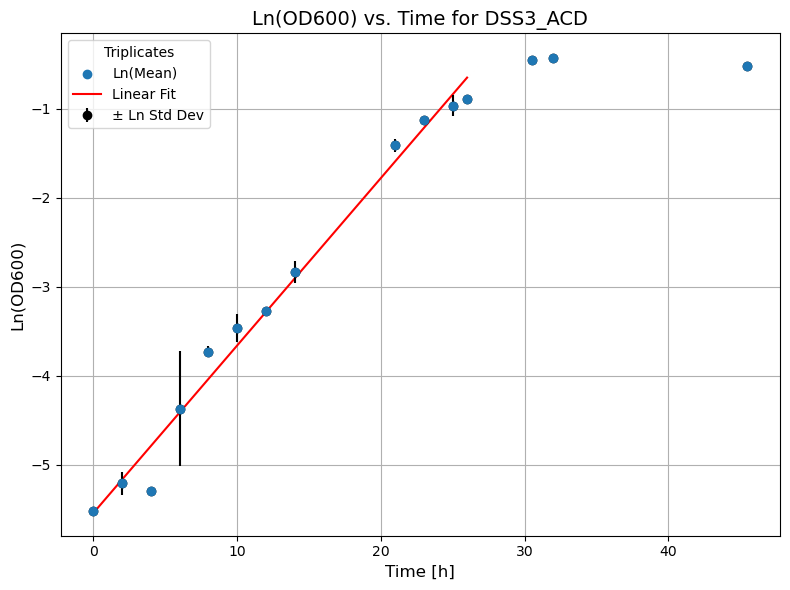

DSS3_ProMM-N+C - Growth Rate: 0.2252, R²: 0.9934, Std Error: 0.0092


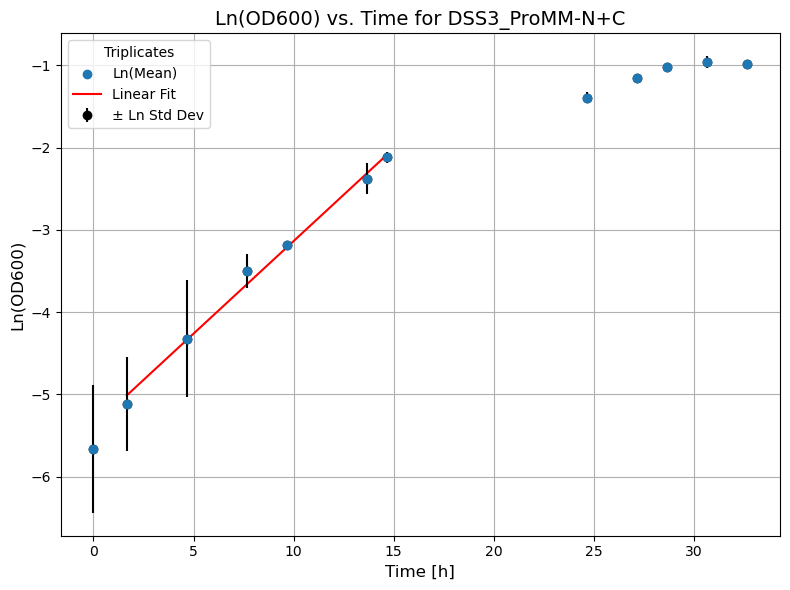

DSS3_ProMM-N-C - No measurable growth. Growth Rate set to 0.


/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


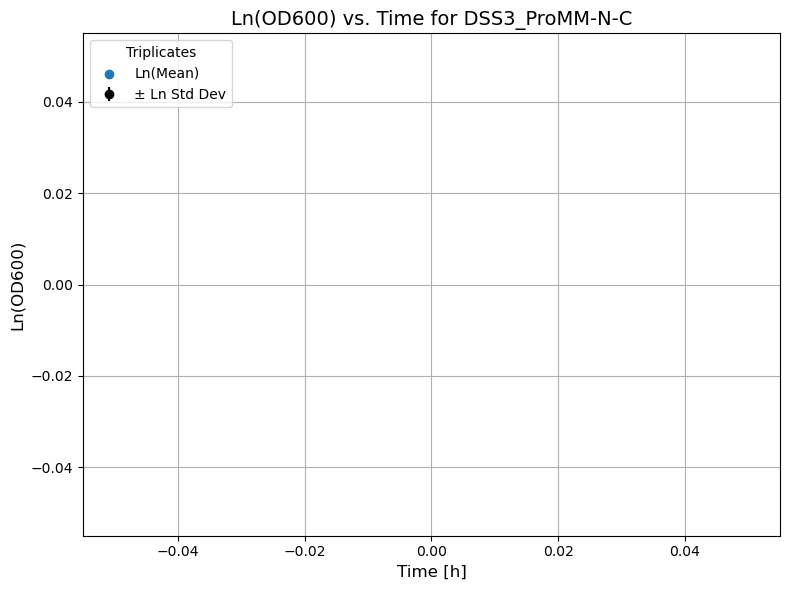

DSS3_ProMM+N-C - No measurable growth. Growth Rate set to 0.


/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


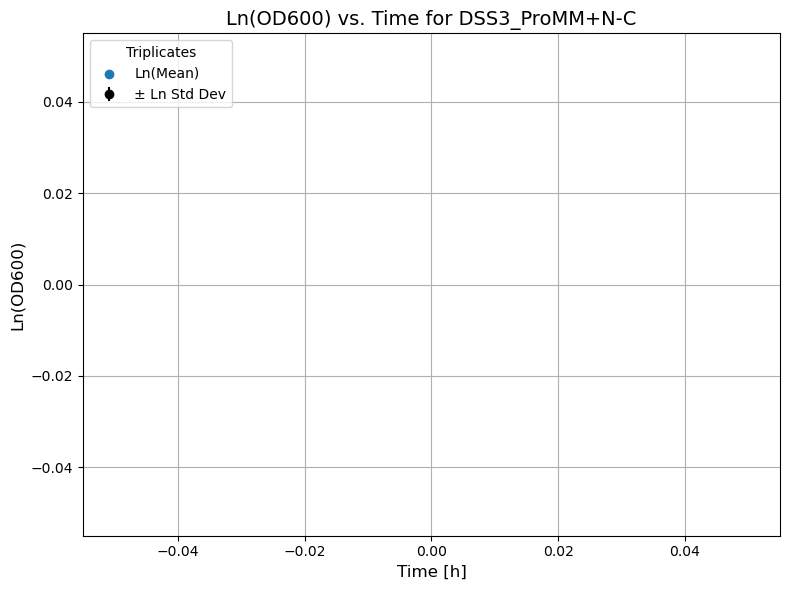

/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_46875/2855809132.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(ordered_growth_rates.keys()), y=list(ordered_growth_rates.values()), palette='viridis', ax=ax)


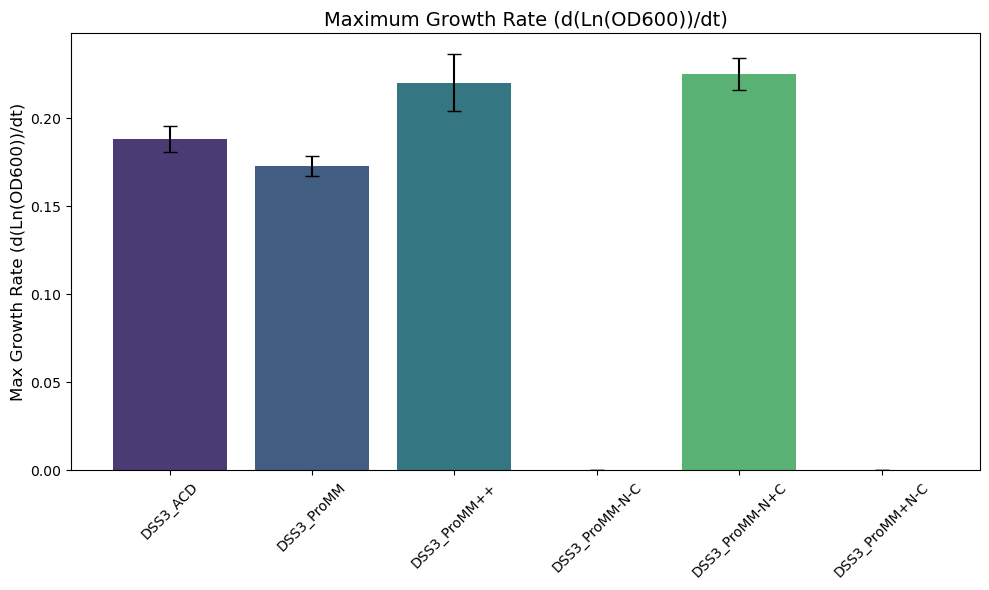

({'DSS3_ProMM++': 0.22024736016856933,
  'DSS3_ProMM': 0.172756379480139,
  'DSS3_ACD': 0.18818695978721242,
  'DSS3_ProMM-N+C': 0.2251827807686021,
  'DSS3_ProMM-N-C': 0,
  'DSS3_ProMM+N-C': 0},
 {'DSS3_ProMM++': 0.9788945904894193,
  'DSS3_ProMM': 0.9958151225754025,
  'DSS3_ACD': 0.9845516883729962,
  'DSS3_ProMM-N+C': 0.99339440119906,
  'DSS3_ProMM-N-C': 0,
  'DSS3_ProMM+N-C': 0},
 {'DSS3_ProMM++': 0.016169985983490533,
  'DSS3_ProMM': 0.0055995884686411415,
  'DSS3_ACD': 0.007454367099375708,
  'DSS3_ProMM-N+C': 0.009181220646317045,
  'DSS3_ProMM-N-C': 0,
  'DSS3_ProMM+N-C': 0})

In [35]:
growth_rate_linreg_barplot(blankcorr_dic)

In [45]:
# Anova analysis for this dataset. 
def linreg_anova(filenames_dic):
    growth_rates = {}  # Dictionary to store individual triplicate growth rates per sample

    for key, df in filenames_dic.items():
        # Convert time to hours
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Store individual triplicate growth rates
        triplicate_rates = []

        # Log-transform triplicates
        log_df = df.iloc[:, 1:4].apply(np.log)

        # Replace -inf (log(0)) with NaN for easier checking
        log_df = log_df.replace(-np.inf, np.nan)

        log_means, log_stds = mean_std(log_df)

        # Filter timepoints
        X = df['Time_hr'].values.reshape(-1, 1)

        if key == list(filenames_dic.keys())[0]:
            valid_indices = ~df.index.isin([6, 7, 8])
        elif key == list(filenames_dic.keys())[1]:
            valid_indices = ~df.index.isin([0, 1, 2, 3, 10])
        elif key == list(filenames_dic.keys())[2]:
            valid_indices = ~df.index.isin([12, 13, 14])
        elif key == list(filenames_dic.keys())[3]:
            valid_indices = ~df.index.isin([0, 7, 8, 9, 10, 11])
        else:
            valid_indices = np.ones(len(df), dtype=bool)

        X_filtered = X[valid_indices]

        # Perform linear regression on each triplicate separately
        for col in log_df.columns:
            y = log_df[col][valid_indices].values.reshape(-1, 1)

            # Check if all values are NaN or constant
            if np.isnan(y).all() or np.nanstd(y) == 0:
                slope = 0
                print(f"{key} - {col} has no measurable growth. Growth Rate set to 0.")
            else:
                model = LinearRegression()
                model.fit(X_filtered[~np.isnan(y).flatten()], y[~np.isnan(y).flatten()])
                slope = model.coef_[0][0]  # Extract slope

            triplicate_rates.append(slope)

        growth_rates[key] = triplicate_rates

    # Convert dictionary to list of lists for ANOVA
    grouped_growth_rates = list(growth_rates.values())

    # Perform ANOVA if we have at least two groups
    if len(grouped_growth_rates) > 1:
        f_stat, p_value = f_oneway(*grouped_growth_rates)
        print(f"ANOVA results: F = {f_stat:.4f}, p = {p_value:.4e}")
    else:
        print("Not enough groups for ANOVA.")

    # Prepare data for boxplot (long format)
    data = []
    for sample, rates in growth_rates.items():
        for rate in rates:
            data.append({'Sample': sample, 'Growth Rate': rate})
    
    df_plot = pd.DataFrame(data)

    # **Custom order for the samples**
    custom_order = ["DSS3_ACD", "DSS3_ProMM", "DSS3_ProMM++", "DSS3_ProMM-N-C", "DSS3_ProMM-N+C", "DSS3_ProMM+N-C"]

    # Visualization (Box Plot)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Sample", y="Growth Rate", data=df_plot, palette="viridis", order=custom_order)
    sns.stripplot(x="Sample", y="Growth Rate", data=df_plot, color='black', alpha=0.7, jitter=True, order=custom_order)  # Show triplicates
    plt.title("Growth Rates", fontsize=14)
    plt.ylabel("Max Growth Rate (d(Ln(OD600))/hr)", fontsize=12)
    plt.xticks(rotation=45)
    #plt.savefig("Linregress_boxplot.pdf", format="pdf")
    plt.show()

    return df_plot  # Return the processed dataframe for reference

ANOVA results: F = 5.8382, p = 2.0576e-02


/var/folders/hb/hntvhz5j0j15vb_5h21tbhph0000gn/T/ipykernel_46875/3007555403.py:76: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Sample", y="Growth Rate", data=df_plot, palette="viridis", order=custom_order)


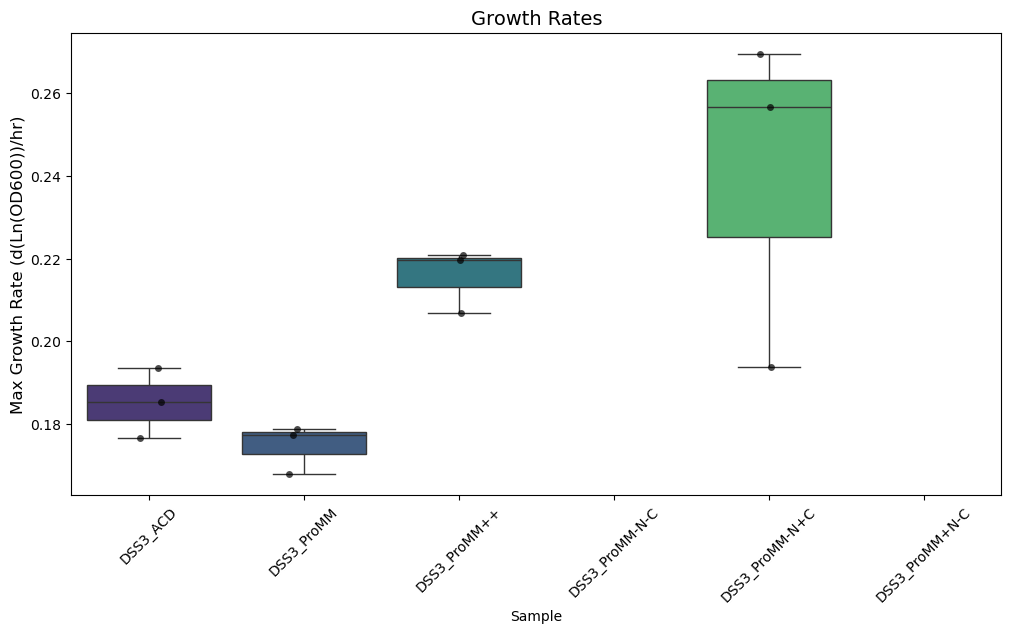

In [46]:
df_growth_rates = linreg_anova(blankcorr_dic)

## How to incorporate Flow cytometry data

Next we want to correct for FCM values / cell counts. Therefore, we take the FCM raw counts µl-1, determine mean and std, blank correct with FCM data of filtered, sterilized, filtered seawater and media blanks. 
To account for the dilution to 200 µl we multiply the number by 200, and then by 25 ml to convert from number of cells per microliter, to number of cells in the 25 ml sample. This cell count can then be used to correct the growth rate from OD600 to rates cells per hour. 

In [101]:
# Load data
FCM = pd.read_csv('FCM_DSS3_ML.txt', delimiter='\t')

# Filter out rows that are not mid-log (ML) phase samples
ML = FCM[FCM['Sample'].str.contains('ML|^NC|^ProMM|^ACD|^Casein', regex=True)].copy()

# Calculate total cells in culture: Events/µl * 25,200 (25 ml + 200 ul)
ML['Cells_in_culture'] = ML_data['Events/ul ML'] * 25200

def compute_growth_rate_cells(blankcorr_dic, ML):
    for condition, df in blankcorr_dic.items():
        # Get the harvest time for the current condition
        harvest_time_row = ML[ML['Sample'].str.contains(condition)]

        if harvest_time_row.empty:
            print(f"No matching harvest time for {condition}")
            continue

        harvest_time = float(harvest_time_row['ML Harvest [hr]'])
        cells_in_culture = float(harvest_time_row['Cells_in_culture'])
        growth_rate_ln = float(harvest_time_row['Growth rate'])  # lnOD/hr

        # Find the closest time point in the blankcorr dataset
        closest_idx = (df['Time_hr'] - harvest_time).abs().idxmin()
        log_mean_at_harvest = df.loc[closest_idx, 'Log_Mean']

        # Calculate conversion factor (cells per lnOD)
        conversion_factor = cells_in_culture / log_mean_at_harvest

        # Calculate growth rate in cells/hr
        growth_rate_cells = growth_rate_ln * conversion_factor

        # Store in the dataframe (optional)
        blankcorr_dic[condition].loc[closest_idx, 'Growth_rate_cells'] = growth_rate_cells

        print(f"{condition}: Harvest time = {harvest_time} hr, lnOD = {log_mean_at_harvest:.3f}, "
              f"cells = {cells_in_culture:.2e}, growth = {growth_rate_cells:.2e} cells/hr")

compute_growth_rate_cells(blankcorr_dic, ML)

error: multiple repeat at position 11

# ARCHIVE

In [14]:
def growth_rate_bar(filenames_dic):
    max_derivatives = []
    keys = []

    for key, df in filenames_dic.items():
        
        # Convert time to minutes and store original TIME
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Take the natural logarithm of each individual measurement (only for columns 1 to 3)
        log_df = df.iloc[:, 1:4].apply(np.log)  # Apply np.log only to the OD columns

        # Calculate the mean and std of the log-transformed values
        log_means, log_stds = mean_std(log_df)

        # Add mean and std columns to the DataFrame for plotting
        df['Log_Mean'] = log_means
        df['Log_Std'] = log_stds

        colors=sns.color_palette("viridis", n_colors=9)

        # Calculate the derivative of the log-transformed mean values with respect to time
        df['Derivative'] = np.gradient(df['Log_Mean'], df['Time_hr'])

        # Find the maximum derivative and its standard deviation
        max_derivative = df['Derivative'].max()
        max_derivative_std = df['Derivative'].std()

        max_derivatives.append((max_derivative, max_derivative_std))
        keys.append(key)

    # Create a box plot for each sample
    plt.figure(figsize=(10, 6))
    for i, (max_derivative, max_derivative_std) in enumerate(max_derivatives):
        plt.bar(keys[i], max_derivative, yerr=max_derivative_std, capsize=5, label=f'{keys[i]}', color=colors[i])

    # Customize the plot
    plt.title("Maximum Growth Rate (d(Ln(OD600))/dt)", fontsize=14)
    plt.ylabel("Max Growth Rate (d(Ln(OD600))/dt)", fontsize=12)
    plt.legend(title="Samples", loc='upper left')
    plt.grid()
    plt.tight_layout()
    #plt.savefig(f"{key}_log_growth_rate", format="pdf")
    plt.show()
    return log_df

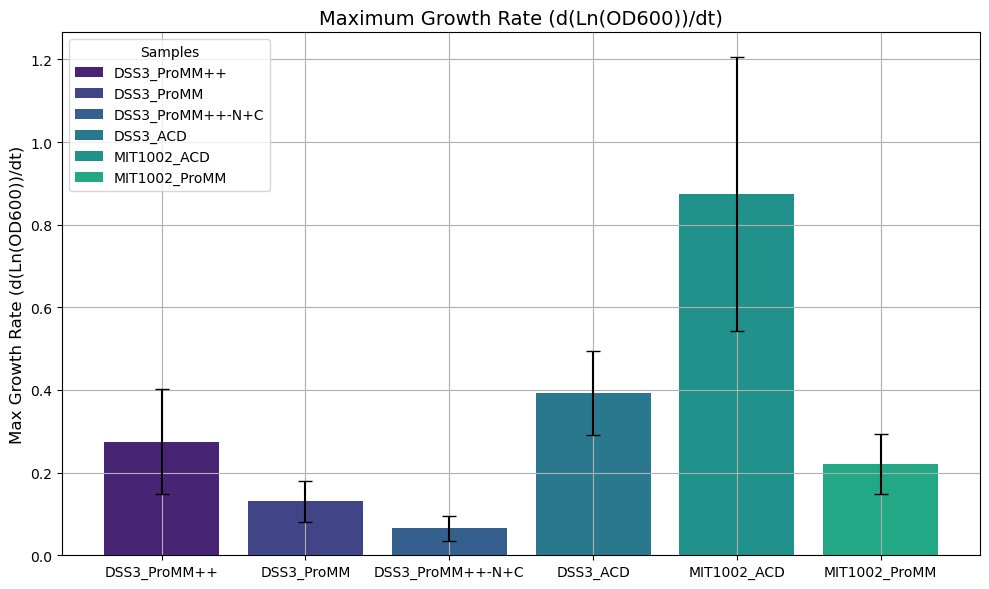

,1,2,3
0,-3.352407,-3.324236,-3.324236
1,-3.296837,-3.296837,-3.270169
2,-3.194183,-3.218876,-3.101093
3,-2.975930,-2.975930,-2.975930
4,-2.617296,-2.645075,-2.488915
5,-2.032558,-2.095571,-2.087474
6,-2.244316,-2.253795,-2.253795
7,-2.111965,-2.111965,-2.087474
8,-2.002481,-2.002481,-1.973281
9,-1.857899,-1.851509,-1.877317


In [15]:
growth_rate_bar(blankcorr_dic)

### ANOVA

In [60]:
def linreg_anova(filenames_dic):
    growth_rates = {}  # Dictionary to store individual triplicate growth rates per sample

    for key, df in filenames_dic.items():
        # Convert time to hours
        df['Time_hr'] = df['Time'].apply(timetohours)

        # Store individual triplicate growth rates
        triplicate_rates = []

        # Log-transform triplicates
        log_df = df.iloc[:, 1:4].apply(np.log).fillna(-5.521461)
        log_means, log_stds = mean_std(log_df)

        # Filter timepoints
        X = df['Time_hr'].values.reshape(-1, 1)

        if key == list(filenames_dic.keys())[0]:
            valid_indices = ~df.index.isin([6, 7, 8])
        elif key == list(filenames_dic.keys())[1]:
            valid_indices = ~df.index.isin([0, 1, 2, 3, 10])
        elif key == list(filenames_dic.keys())[2]:
            valid_indices = ~df.index.isin([12, 13, 14])
        elif key == list(filenames_dic.keys())[3]:
            valid_indices = ~df.index.isin([0, 9, 10, 11])
        else:
            valid_indices = np.ones(len(df), dtype=bool)

        X_filtered = X[valid_indices]

        # Perform linear regression on each triplicate separately
        for col in log_df.columns:
            y = log_df[col][valid_indices].values.reshape(-1, 1)

            model = LinearRegression()
            model.fit(X_filtered, y)

            slope = model.coef_[0][0]  # Extract slope
            triplicate_rates.append(slope)

        growth_rates[key] = triplicate_rates

    # Convert dictionary to list of lists for ANOVA
    grouped_growth_rates = list(growth_rates.values())

    # Perform ANOVA if we have at least two groups
    if len(grouped_growth_rates) > 1:
        f_stat, p_value = f_oneway(*grouped_growth_rates)
        print(f"ANOVA results: F = {f_stat:.4f}, p = {p_value:.4e}")
    else:
        print("Not enough groups for ANOVA.")

    # Prepare data for boxplot (long format)
    data = []
    for sample, rates in growth_rates.items():
        for rate in rates:
            data.append({'Sample': sample, 'Growth Rate': rate})
    
    df_plot = pd.DataFrame(data)

    # **Custom order for the samples**
    custom_order = ["DSS3_ACD", "DSS3_ProMM", "DSS3_ProMM++", "DSS3_ProMM-N+C"]

    # Visualization (Box Plot)
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="Sample", y="Growth Rate", data=df_plot, palette="viridis", order=custom_order)
    sns.stripplot(x="Sample", y="Growth Rate", data=df_plot, color='black', alpha=0.7, jitter=True, order=custom_order)  # Show triplicates
    plt.title("Growth Rates", fontsize=14)
    plt.ylabel("Max Growth Rate (d(Ln(OD600))/hr)", fontsize=12)
    plt.xticks(rotation=45)
    plt.savefig("Linregress_boxplot.pdf", format="pdf")
    plt.show()

    return df_plot  # Return the processed dataframe for reference

# Run the updated ANOVA function with individual triplicate growth rates
df_growth_rates = linreg_anova(blankcorr_dic)


/Users/fadimestemmer/miniconda3/envs/MS_plot/lib/python3.9/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


ValueError: Input y contains infinity or a value too large for dtype('float64').